# DATA 612 FINAL PROJECT
Amazon Product Recommender Model Using Reviews

* Farhod Ibragimov
* Gillian McGovern

## Objective

Create an offline Amazon product (specifically Amazon fashion products) recommender model using user ratings and reviews.

## Project Agenda

* Perform EDA
* Create a content based LLM recommender model via BERT
* Create a collaborative filtering ALS model via Spark
* Create a hybrid recommender model
* Create an image analysis recommender model
* Evaluate model
* Deploy a recommender

## Data Sources

Source: https://amazon-reviews-2023.github.io/

This is a large-scale Amazon Reviews dataset, collected in 2023 by McAuley Lab, and it includes rich features such as:

*   User Reviews (ratings, text, helpfulness votes, etc.);
*   Item Metadata (descriptions, price, raw image, etc.);
*   Links (user-item / bought together graphs).


User review structure can be found [here](https://amazon-reviews-2023.github.io/#for-user-reviews) and item metadata structure can be found [here](https://amazon-reviews-2023.github.io/#for-item-metadata).

We will be specifically looking at the Amazon Fashion category of products, which includes:

* 2.0M Users
* 825.9K Products
* 2.5M Ratings/Reviews

The original data is in JSON format.

## Data Storage

Hugging Face Storage:

We decided to use Hugging Face, which we will refer to as HF, as our storage for our data since it provides a lot of free storage compared to AWS. [Hugging Face](https://huggingface.co/docs) is an open-source community that builds tools, ML models, and platforms for AI development. HF has a specific focus on data science, machine learning and NLP.

It provides 50 GB of non-persistent disk space for Spaces environment, which is, according to their documentation, a platform that allows users to easily deploy and share machine learning demos, models, and applications. Additionally, HF offers repositories as a place where code and assets can be stored to back up your work, share it with the community, and work in a team. These repositories can be up to 300GB. Datasets on the Hugging Face Hub are considered repositories.

The dataset repository for this project can be found [here](https://huggingface.co/datasets/glavvrach79/my-recsys-data/tree/main).

The original data (JSON files) can be found in the `data` folder, the files we created for this project such as the KNN cache for the BERT item embeddings can be found in the `output` folder.

## Read in the Data

First import the libraries needed:

In [1]:
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
import torch
import pyarrow as pa
import pyarrow.parquet as pq
from pyspark.sql import SparkSession
from sentence_transformers import SentenceTransformer
from huggingface_hub import hf_hub_download
from sklearn.neighbors import NearestNeighbors
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import floor, round, monotonically_increasing_id, col
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, count, explode, rand, when, lit, max as spark_max, min as spark_min, udf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import FloatType
from huggingface_hub import hf_hub_download
import numpy as np
from pyspark.sql.functions import col, count, explode, rand, when, lit, max as spark_max, min as spark_min, udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import FloatType
from huggingface_hub import hf_hub_download
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType
from huggingface_hub import hf_hub_download
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import os
import random
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import torch

from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
from huggingface_hub import hf_hub_download
from pyspark.sql import SparkSession
from pyspark import SparkConf
from huggingface_hub import hf_hub_download

/Users/gillianmcgovern/PyCharmMiscProject/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA (Original Dataset)

Before we create our train, eval, valid datasets to use for our models, let's perform a quick EDA on the entire dataset, reading from local dataset for now, to see what we are working with:

Dataset shape: (2500939, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500939 entries, 0 to 2500938
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      object        
 1   parent_asin  object        
 2   rating       int64         
 3   timestamp    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 76.3+ MB
None
             rating                      timestamp
count  2.500939e+06                        2500939
mean   3.969467e+00  2018-11-29 06:21:51.333767424
min    1.000000e+00            2002-05-07 01:51:28
25%    3.000000e+00            2017-04-11 13:16:35
50%    5.000000e+00  2018-12-27 12:54:30.036999936
75%    5.000000e+00  2020-09-02 18:27:05.002500096
max    5.000000e+00     2023-09-11 03:24:38.515000
std    1.427171e+00                            NaN
Number of unique users: 2035490
Number of unique product: 825869


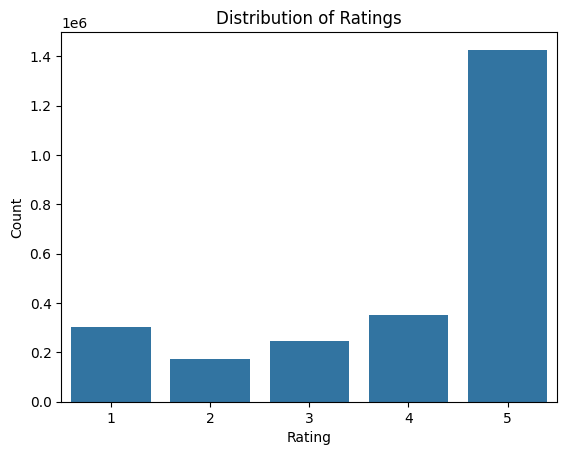

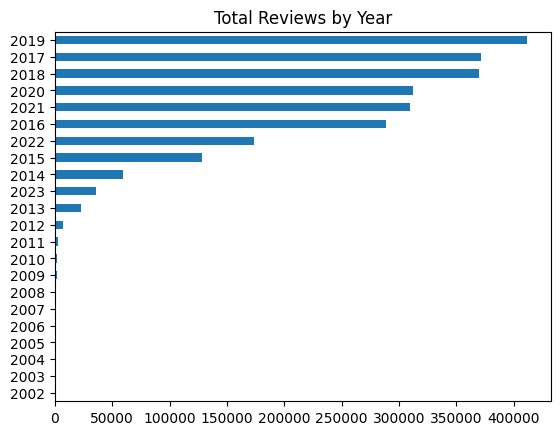

In [5]:
# Only need to run this once
if False:
    # EDA for original dataset
    import matplotlib.pyplot as plt
    import seaborn as sns

    original_data_unfiltered = pd.read_parquet('output/full_review_non_filtered.parquet')

    # Print shape, info, and summary stats
    print("Dataset shape:", original_data_unfiltered.shape)
    print(original_data_unfiltered.info())
    print(original_data_unfiltered.describe())

    # Number of users and products
    print(f"Number of unique users: {original_data_unfiltered['user_id'].nunique()}")
    print(f"Number of unique product: {original_data_unfiltered['parent_asin'].nunique()}")

    # Plot distribution of ratings
    sns.countplot(x='rating', data=original_data_unfiltered)
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()

    # Total reviews by year
    original_data_unfiltered["timestamp"].dt.year.value_counts(ascending = True).plot(kind = "barh")
    plt.title("Total Reviews by Year")
    plt.ylabel("")
    plt.show()

There are 2,500,939 ratings, 2,035,490 users, and 825,869 Amazon products in the original dataset. The average rating is 4.0 with a standard deviation of 1.4. Additionally, unsurprisingly, the ratings are skewed very high as most ratings are a 5.

Most of the reviews come from 2017-2019, with 2019 having the highest amount of reviews. The earliest review comes from 2002 - there is not a high number of reviews for earlier years. Since we want to create a relevant model, let's focus on the most recent data coming from 2021-2023.

### Create Train, Test, Valid Datasets

We first read in the code from local JSON files, `Amazon_Fashion.jsonl` which is the original data, and `meta_Amazon_Fashion.jsonl` which is the product metadata file. JSON is inefficiently, large so we must convert the files to parquet first before storing on HF. The reason a parquet file type was chosen is that parquet files are usually 2-5c smaller than JSON, and we want to decrease our storage on HF and improve the speed of our models. Parquet file's columnar store file is makes the data easier to compress and query, which is extremely important for large datasets.

Since the datasets are so large, we read files in chunks via Pandas. Reading in the data in smaller, manageable chunks is a more memory efficient way to process the data. This also helps with scalabilty, since this will work for all different file sizes. Lastly, reading in chunks via Pandas makes it easy to filter and transform the data along the way, which could crash a system's RAM if used done for one large dataset.

As mentioned, we will only look at the most recent data from 2021-2023 to narrow down the data. 80% of the original data will go to the `train.parquet`, while 10% will go to `test.parquet` and `valid.parquet`.

After the below code chunk ran, we uploaded the parquets file to HF manually.



In [3]:
if False:
    # CONFIG 
    REVIEW_PATH = r"C:\CUNY_MSDS\DATA612\AMAZON_PROJECT\data\Appliances.jsonl"
    META_PATH   = r"C:\CUNY_MSDS\DATA612\AMAZON_PROJECT\data\meta_Appliances.jsonl"
    OUT_DIR     = r"C:\CUNY_MSDS\DATA612\AMAZON_PROJECT\output"
    CHUNK_SIZE  = 200_000   # tune based on your machine's RAM
    SEED        = 42


    os.makedirs(OUT_DIR, exist_ok=True)

    #LOAD METADATA 
    meta_pd = pd.read_json(
        r"C:\CUNY_MSDS\DATA612\AMAZON_PROJECT\data\meta_Appliances.jsonl",
        lines=True
    )[["parent_asin", "average_rating", "rating_number"]]

    writers = {"train": None, "valid": None, "test": None}

    # STREAM, FILTER, SPLIT, AND WRITE
    for chunk in pd.read_json(
        r"C:\CUNY_MSDS\DATA612\AMAZON_PROJECT\data\Appliances.jsonl",
        lines=True,
        chunksize=CHUNK_SIZE
    ):
        # 1) keep needed cols + timestamp
        chunk = chunk[["user_id", "parent_asin", "rating", "timestamp", "text"]]

        # 2) filter to years 2021–2023
        dt = pd.to_datetime(chunk["timestamp"], unit="ms")
        mask_year = dt.dt.year.between(2021, 2023)
        chunk = chunk.loc[mask_year]
        if chunk.empty:
            continue

        # 3) assign random float for splitting
        rng = np.random.RandomState(SEED)
        chunk["_rand"] = rng.rand(len(chunk))

        # 4) merge metadata
        chunk = chunk.merge(meta_pd, on="parent_asin", how="left")

        # 5) define split masks
        masks = {
            "train": chunk["_rand"] <  0.8,
            "valid": (chunk["_rand"] >= 0.8) & (chunk["_rand"] < 0.9),
            "test":  chunk["_rand"] >= 0.9
        }

        # 6) write each split to its Parquet
        for split, m in masks.items():
            sub = chunk.loc[m, [
                "user_id",
                "parent_asin",
                "rating",
                "text",
                "average_rating",
                "rating_number"
            ]]
            if sub.empty:
                continue
            tbl = pa.Table.from_pandas(sub, preserve_index=False)
            path = os.path.join(OUT_DIR, f"{split}.parquet")
            if writers[split] is None:
                writers[split] = pq.ParquetWriter(path, schema=tbl.schema)
            writers[split].write_table(tbl)

    # close Parquet writers
    for w in writers.values():
        if w:
            w.close()

    print("Finished writing filtered splits to:", OUT_DIR)
    print("  •", os.path.join(OUT_DIR, "train.parquet"))
    print("  •", os.path.join(OUT_DIR, "valid.parquet"))
    print("  •", os.path.join(OUT_DIR, "test.parquet"))


In [4]:
if False:    
    import pyarrow.parquet as pq

    for split in ("train", "valid", "test"):
        path = rf"C:\CUNY_MSDS\DATA612\AMAZON_PROJECT\output\{split}.parquet"
        pf = pq.ParquetFile(path)
        print(f"{split.capitalize()} split: {pf.metadata.num_rows} reviews")


### Reading from HF

The original data that was manually added to HF can be found in the `data` folder. To read our data, we use HF's [`hf_hub_download`](https://huggingface.co/docs/huggingface_hub/en/guides/download) which takes in the `repo_id`, `repo_type` and `filename`. The `hf_hub_download()` function downloads the remote file, caches it on disk (in a version-aware way), and returns its local file path. After creating the local path, we can then easily read in the parquet using Spark or Pandas.

The way a notebook is able to connect to the HF API is through an API token which can be created via the console. After the token has been generated, it can then be set as an environment variable `HF_TOKEN`.

### EDA (Train Parquet)

We next read in the `train.parquet` from HF and did another quick EDA for our input data:

In [2]:
# EDA on training data

if True:
    spark = SparkSession.builder \
        .appName("CheckRatingRange") \
        .config("spark.driver.memory","4g") \
        .getOrCreate()

    hf_path_reviews = hf_hub_download(
        repo_id="glavvrach79/my-recsys-data", repo_type="dataset",
        subfolder="output", filename="train.parquet"
    )

    train = spark.read.parquet(hf_path_reviews).select("user_id", "parent_asin", "rating")

    # 1) min & max
    train.selectExpr("min(rating) AS min_rating", "max(rating) AS max_rating") \
        .show()

    # 2) basic summary (mean, stddev, etc.)
    train.describe("rating").show()

    # 3) breakdown by rating value
    train.groupBy("rating").count().orderBy("rating").show(5, truncate=False)

    unique_users = train.select("user_id").distinct().count()
    print(f"Number of unique names: {unique_users}")

    unique_products = train.select("parent_asin").distinct().count()
    print(f"Number of unique products: {unique_products}")

    spark.stop()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/21 16:00:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+----------+
|min_rating|max_rating|
+----------+----------+
|         1|         5|
+----------+----------+

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|             99906|
|   mean| 4.015464536664465|
| stddev|1.4513139113832125|
|    min|                 1|
|    max|                 5|
+-------+------------------+

+------+-----+
|rating|count|
+------+-----+
|1     |12784|
|2     |6364 |
|3     |8659 |
|4     |10815|
|5     |61284|
+------+-----+

Number of unique names: 97888
Number of unique products: 6907


For our model input data, we have 99,906 ratings, 97,888 users and 6,907 products. The other statistics are all pretty much the same, with the minimum rating of 1 and a maximum rating of 5. This is a much better dataset to use for our models.

## BERT Content Based Recommender Model

For our first recommender, we chose a content based recommender. Content based filtering is a recommendation method that uses item features to select and return similar, recommended items.

For our content based recommender, we wanted to use a LLM recommender to generate our item features. For this, we decided to use `BERT` (Bidirectional Encoder Representations from Transformers). Created by researchers at Google in 2018, `BERT` is a powerful language model that understands the meaning and context of the words. We specifically chose a dataset with user reviews to explore how effective `BERT` can be for a recommender. `BERT` is able to use the surrounding words to influence the meaning of a word in a sentence or paragraph, which is how BERT is able to find context within a sentence. Using reviews will make our recommender more useful compared to using `BERT` only with product descriptions. Reviews are more conversational and contain more nuances than a simple production description. Reviews also reflect that actual views of a user, which is more informational than just a rating from 1-5. Lastly, `BERT` has an input limitation, so using reivews is the perfect size of text for `BERT` to process.

We use a pre-trained `BERT` sentence embedding model (`all-MiniLM-L6-v2`) to convert each user's review into a high-quality numerical vector. This model was chosen due to it being a smaller, more efficient version of `BERT`, which is critical with larger datasets. These contextual embeddings are much richer than TF-IDF vectors, which can only discover word significance.

We then use the cosine similarity of the item embeddings to find a similarity score for each pair of Amazon products in the ratings dataset. The expectation is that BERT will give us more nuanced and conceptually relevant recommendations.

## What is cosine similarity?

Cosine Similarity

Cosine Similarity is a metric used to measure the similarity between two non-zero vectors in an inner product space. It calculates the cosine of the angle between them. When used in text analysis, it helps determine how similar two documents are, regardless of their size.

A cosine value of 0 indicates that the two vectors are orthogonal (not similar at all), a value of 1 indicates that the vectors are identical, and a value of -1 indicates the vectors are diametrically opposite. For text data that has been converted into numerical vectors (like with `BERT`), cosine similarity is a very effective way to measure content similarity.

The formula for Cosine Similarity between two vectors, A and B, is:

$$
\text{similarity} = \cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}
$$


Where:

* $\mathbf{A}$
  and $\mathbf{B}$
  are the components of vectors A and B, respectively.

* ${\mathbf{A} \cdot \mathbf{B}}$ is the dot product of the two vectors.

* $\|\mathbf{A}\|$ and $\|\mathbf{B}\|$ are the magnitudes (or Euclidean norms) of the vectors.

### Create BERT Embeddings

To create the embeddings, we read in our `train.parquet`, group by the item ID , `parent_asin`, and focus on the `text` column which contains the user's review for a product. Since this file is large, we decided to use Spark which is great for handling large datasets. We do the embeddings in batches, setting the batch size to 64 to improve performance and memory usage. After the embeddings were created, they were manually uploaded to HF to be used later in the model.

The drawback of `BERT` is that it can be computationally expense, so the below code takes a long time. This is why we only ran this code once and stored it as a parquet in HF to be used later.

In [6]:
#DO NOT RUN THIS CELL UNLESS EMBEDDINGS ARE NEEDED
if False:
    import os
    import torch
    import pyarrow as pa
    import pyarrow.parquet as pq
    from pyspark.sql import SparkSession
    from sentence_transformers import SentenceTransformer
    from huggingface_hub import hf_hub_download

    HF_REPO      = "glavvrach79/my-recsys-data"
    HF_SUBFOLDER = "output/embeddings"
    FNAME        = "item_embeddings.parquet"

    LOCAL_TRAIN  = r"C:\CUNY_MSDS\DATA612\AMAZON_PROJECT\output\train.parquet"
    EMB_OUT      = r"C:\CUNY_MSDS\DATA612\AMAZON_PROJECT\output\embeddings\item_embeddings.parquet"

    DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
    SAMPLE_PER   = 5
    BATCH_SIZE   = 64

    os.makedirs(os.path.dirname(EMB_OUT), exist_ok=True)
    print(f"Using device: {DEVICE}\n")

    def is_good_parquet(path: str) -> bool:
        """Try a light PyArrow read to confirm the file is a valid Parquet."""
        try:
            pq.read_table(path, columns=[])  # only footer
            return True
        except Exception:
            return False

    downloaded = False

    # if a local copy already exists & is valid, use it 
    if os.path.exists(EMB_OUT) and is_good_parquet(EMB_OUT):
        print(f"Found valid local embeddings → {EMB_OUT}\n")
        downloaded = True

    # else try downloading from HF 
    if not downloaded:
        try:
            hf_path = hf_hub_download(
                repo_id=HF_REPO,
                repo_type="dataset",
                subfolder=HF_SUBFOLDER,
                filename=FNAME,
            )
            print(f"📦 Downloaded HF embeddings → {hf_path}")
            if is_good_parquet(hf_path):
                print("HF parquet loads OK. Using HF version.\n")
                EMB_OUT = hf_path
                downloaded = True
            else:
                print("HF parquet is corrupt—will recompute locally.\n")
        except Exception as e:
            print(f"Could not fetch from HF ({e!r}); will compute locally.\n")

    # if still not obtained, recompute locally 
    if not downloaded:
        print("▶️ Computing embeddings locally…\n")
        spark = SparkSession.builder \
            .appName("ComputeItemEmbeddings") \
            .config("spark.driver.memory","16g") \
            .getOrCreate()

        df = spark.read.parquet(LOCAL_TRAIN).select("parent_asin", "text")
        pdf = df.toPandas()
        spark.stop()

        model = SentenceTransformer("all-MiniLM-L6-v2", device=DEVICE)
        writer = None

        for pid, group in pdf.groupby("parent_asin", sort=False):
            samples = group["text"].sample(
                n=min(len(group), SAMPLE_PER),
                random_state=42
            ).tolist()

            emb_batch = model.encode(
                samples,
                batch_size=BATCH_SIZE,
                show_progress_bar=False,
                convert_to_numpy=True
            )
            mean_emb = emb_batch.mean(axis=0)

            data = {"parent_asin": [pid]}
            for i, val in enumerate(mean_emb):
                data[f"emb_{i}"] = [float(val)]
            table = pa.Table.from_pydict(data)

            if writer is None:
                writer = pq.ParquetWriter(EMB_OUT, schema=table.schema)
            writer.write_table(table)

        if writer:
            writer.close()

        print(f"✅ Wrote item embeddings locally → {EMB_OUT}\n")

    # preview final 
    print(f" Final embeddings path → {EMB_OUT}\n")
    spark = SparkSession.builder \
        .appName("PreviewEmbeddings") \
        .config("spark.driver.memory","4g") \
        .getOrCreate()

    def try_spark_read(path: str):
        try:
            return spark.read.parquet(path)
        except Exception as e:
            print(f"Spark read failed on `{path}`:\n   {e}")
            return None

    emb_df = try_spark_read(EMB_OUT)

    # ── If Spark failed on the HF‐cached file, fall back to pandas → Spark ──────
    if emb_df is None:
        import pandas as pd
        print("Falling back to pandas.read_parquet …")
        pdf = pd.read_parquet(EMB_OUT)
        emb_df = spark.createDataFrame(pdf)

    emb_df.show(5, truncate=50)
    print("Total items:", emb_df.count())
    spark.stop()


### Create KNN Cache

Our next NLP task is finding the 'k' nearest neighbors, which is embeddings for this case, based off their cosine similarity. To do this, we read in our embeddings and metadata stored on HF (created above). We then attach the item ID to the embeddings and use `sklearn.neighbors.NearestNeighbors` to find the top 5 nearest items (based off the text embeddings). Again, a higher cosine score means a more closely related text.

We then create a dataframe (parquet file) that includes `item_id`, `item_title`, `rank`, `neighbor_id`, `neighbor_title`, and `distance` (which is the similarity score). This KNN cache can be used later for our recommender model.

In [7]:
# CONFIG 
HF_REPO      = "glavvrach79/my-recsys-data"
HF_SUBFOLDER_KNN = "output"
HF_SUBFOLDER = "output/embeddings"
FNAME        = "item_embeddings_weighted.parquet"
TRAIN_NAME   = "train.parquet"
TEST_NAME  = "test.parquet"
VALID_NAME = "valid.parquet"
FULL_REVIEW_NAME = "full_review.parquet"
KNN_NAME = "knn_cache_weighted.parquet"

import os
from huggingface_hub import hf_hub_download

# Try to read META_PATH from the env; if not set, download from HF
META_PATH = os.getenv(
    "META_PATH",
    hf_hub_download(
        repo_id="glavvrach79/my-recsys-data",
        repo_type="dataset",
        subfolder="data",
        filename="meta_Amazon_Fashion.jsonl",
    )
)

print("Loading metadata from:", META_PATH)


TOP_K = 5
OUT_PATH = os.getenv('OUT_PATH', "C:\CUNY_MSDS\DATA612\AMAZON_PROJECT\output\knn_cache.parquet")

#os.makedirs(os.path.dirname(LOCAL_OUT), exist_ok=True)

def load_or_build_cache():
    # try HF download + read
    try:
        hf_cache = hf_hub_download(
            repo_id=HF_REPO,
            repo_type="dataset",
            subfolder=HF_SUBFOLDER_KNN,
            filename=KNN_NAME,
        )
        print("Downloaded KNN cache from HF:", hf_cache)
        cache = pd.read_parquet(hf_cache)
        print("Loaded cache from HF!")
        return cache
    except Exception as e:
        print(f"HF cache unavailable ({e}); building locally…")

    
    # download embeddings
    hf_emb = hf_hub_download(
        repo_id=HF_REPO,
        repo_type="dataset",
        subfolder=HF_SUBFOLDER,
        filename=FNAME,
    )
    df_emb = pd.read_parquet(hf_emb)

    # metadata
    df_meta = (
        pd.read_json(f'r{META_PATH}', lines=True)
          .loc[:, ["parent_asin", "title"]]
          .rename(columns={"parent_asin":"item_id", "title":"product_title"})
    )

    df = (
        df_emb.rename(columns={"parent_asin":"item_id"})
              .merge(df_meta, on="item_id", how="left")
    )

    X        = df.filter(regex="^emb_").values
    item_ids = df["item_id"].to_numpy()
    titles   = df["product_title"].to_numpy()

    nn = NearestNeighbors(n_neighbors=TOP_K+1, metric="cosine")
    nn.fit(X)
    distances, indices = nn.kneighbors(X)

    title_map = df.set_index("item_id")["product_title"]

    cache = pd.DataFrame({
        "item_id":        np.repeat(item_ids, TOP_K),
        "item_title":     np.repeat(title_map[item_ids].values, TOP_K),      # ← add this
        "rank":           np.tile(np.arange(1, TOP_K+1), len(item_ids)),
        "neighbor_id":    item_ids[indices[:, 1:]].ravel(),
        "neighbor_title": titles[indices[:, 1:]].ravel(),
        "distance":       distances[:, 1:].ravel(),
    })
    cache.to_parquet(OUT_PATH, index=False)
    print(f"file saved to {OUT_PATH}")
    
    return cache


knn_cache = load_or_build_cache()

Loading metadata from: C:\Users\farho\.cache\huggingface\hub\datasets--glavvrach79--my-recsys-data\snapshots\795af033a9aecbf06b519310f399c59a30152c57\data\meta_Amazon_Fashion.jsonl
Downloaded KNN cache from HF: C:\Users\farho\.cache\huggingface\hub\datasets--glavvrach79--my-recsys-data\snapshots\795af033a9aecbf06b519310f399c59a30152c57\output\knn_cache_weighted.parquet
Loaded cache from HF!


### Create Content Based Model Using BERT Embeddings

With our KNN embeddings cache stored, we can now create a recommender. We created the function `recommend` which takes in an item ID, and returns the top 5 most similar items based off reviews. It uses the KNN embeddings cache, locates the item ID and via `pandas.Series.nsmallest`, finds the top 5 items based off of smallest `distance` value. It then returns a data frame containing with columns neighbor item ID, title, and cosine similarity score (distance).

In [8]:


# ─── HF CONFIG ────────────────────────────────────────────────────────────────
HF_REPO           = "glavvrach79/my-recsys-data"
HF_SUBFOLDER_KNN  = "output"
HF_SUBFOLDER_EMB  = "output/embeddings"
HF_SUBFOLDER_DATA = "data"
TRAIN_NAME        = "train.parquet"
META_NAME         = "meta_Amazon_Fashion.jsonl"
FNAME_EMB         = "item_embeddings_weighted.parquet"
KNN_NAME          = "knn_cache_weighted.parquet"

# ─── LOCAL PATHS ─────────────────────────────────────────────────────────────
os.makedirs(HF_SUBFOLDER_EMB, exist_ok=True)
os.makedirs(HF_SUBFOLDER_KNN, exist_ok=True)

local_train = hf_hub_download(
    repo_id=HF_REPO, repo_type="dataset",
    subfolder=HF_SUBFOLDER_KNN, filename=TRAIN_NAME
)
local_meta = hf_hub_download(
    repo_id=HF_REPO, repo_type="dataset",
    subfolder=HF_SUBFOLDER_DATA, filename=META_NAME
)

local_emb = os.path.join(HF_SUBFOLDER_EMB, FNAME_EMB)
local_knn = os.path.join(HF_SUBFOLDER_KNN,  KNN_NAME)

print("train.parquet →", local_train)
print("meta.jsonl   →", local_meta)

DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLE_PER = 5
BATCH_SIZE = 64

# ─── 1) BUILD EMBEDDINGS IF MISSING ──────────────────────────────────────────
if not os.path.exists(local_emb):
    print("embeddings not found locally. Building weighted SBERT embeddings…")
    train = pd.read_parquet(local_train)
    meta  = (
        pd.read_json(local_meta, lines=True)
          .loc[:, ["parent_asin","title","main_category"]]
          .rename(columns={"parent_asin":"item_id","title":"item_title"})
    )
    df = (
        train
          .rename(columns={"parent_asin":"item_id"})
          .merge(meta, on="item_id", how="left")
    )

    model  = SentenceTransformer("all-MiniLM-L6-v2", device=DEVICE)
    writer = None

    for item_id, group in df.groupby("item_id", sort=False):
        title_emb = model.encode(
            [group["item_title"].iloc[0] or ""],
            batch_size=1, convert_to_numpy=True
        )[0]

        texts = group["text"].dropna().sample(
            n=min(len(group), SAMPLE_PER),
            random_state=42
        ).tolist()
        if texts:
            rev_emb = model.encode(
                texts, batch_size=BATCH_SIZE,
                convert_to_numpy=True
            ).mean(axis=0)
        else:
            rev_emb = np.zeros_like(title_emb)

        comp_emb = np.concatenate([2*title_emb, rev_emb])
        data = {
            "item_id":       [item_id],
            "item_title":    [group["item_title"].iloc[0]],
            "main_category": [group["main_category"].iloc[0]],
        }
        for i,v in enumerate(comp_emb):
            data[f"emb_{i}"] = [float(v)]

        tbl = pa.Table.from_pydict(data)
        if writer is None:
            writer = pq.ParquetWriter(local_emb, schema=tbl.schema)
        writer.write_table(tbl)

    if writer:
        writer.close()
    print("✅ Wrote embeddings to", local_emb)
else:
    print("✅ Embeddings already exist:", local_emb)

# ─── 2) BUILD k‑NN CACHE IF MISSING ───────────────────────────────────────────
if not os.path.exists(local_knn):
    print("🔨 k‑NN cache not found locally. Building index & cache…")
    df_emb   = pd.read_parquet(local_emb)
    X        = df_emb.filter(like="emb_").values
    item_ids = df_emb["item_id"].values
    titles   = df_emb["item_title"].values
    cats     = df_emb["main_category"].values

    TOP_K = 5
    nn = NearestNeighbors(n_neighbors=TOP_K+1, metric="cosine")
    nn.fit(X)
    dists, idxs = nn.kneighbors(X)

    records = []
    for i, pid in enumerate(item_ids):
        for rank, j in enumerate(idxs[i,1:], start=1):
            records.append({
                "item_id":        pid,
                "item_title":     titles[i],
                "main_category":  cats[i],
                "rank":           rank,
                "neighbor_id":    item_ids[j],
                "neighbor_title": titles[j],
                "neighbor_cat":   cats[j],
                "distance":       dists[i,rank]
            })
    cache = pd.DataFrame(records)
    cache.to_parquet(local_knn, index=False)
    print("✅ Wrote k‑NN cache to", local_knn)
else:
    print("✅ k‑NN cache already exists:", local_knn)

# ─── 3) DEMO ─────────────────────────────────────────────────────────────────
# reload both df_emb & cache to be sure we have them in memory
df_emb = pd.read_parquet(local_emb)
cache  = pd.read_parquet(local_knn)

def recommend(item_id, top_k=5, same_cat=True):
    dfk = cache[cache["item_id"] == item_id]
    if same_cat:
        cat = dfk["main_category"].iloc[0]
        dfk = dfk[dfk["neighbor_cat"] == cat]
    return dfk.nsmallest(top_k, "distance")[["neighbor_id","neighbor_title","distance"]]

sample = random.choice(df_emb["item_id"].tolist())
title  = df_emb.set_index("item_id").loc[sample, "item_title"]
print(f"\n🎲 Recommendations for {sample} — “{title}”")
print(recommend(sample))


train.parquet → C:\Users\farho\.cache\huggingface\hub\datasets--glavvrach79--my-recsys-data\snapshots\795af033a9aecbf06b519310f399c59a30152c57\output\train.parquet
meta.jsonl   → C:\Users\farho\.cache\huggingface\hub\datasets--glavvrach79--my-recsys-data\snapshots\795af033a9aecbf06b519310f399c59a30152c57\data\meta_Amazon_Fashion.jsonl
✅ Embeddings already exist: output/embeddings\item_embeddings_weighted.parquet
✅ k‑NN cache already exists: output\knn_cache_weighted.parquet

🎲 Recommendations for B07KZW8X6N — “Hearbeingt Cremation Jewelry Urn Necklace for Ashes, Pet Paw Print Memorial Pendant for Dog Cat Ashes Keepsake Locket for Men for Women”
      neighbor_id                                     neighbor_title  distance
32890  B07PXS9JPX  Hearbeingt Teardrop Urn Necklaces for Ashes Tr...  0.240749
32891  B08YWNWX8C  Jovivi Personalized Photo Cremation Urn Neckla...  0.297532
32892  B089ZYD9XR  Richsteel Moon Cat/Cross/Angel Wing/Forever in...  0.340390
32893  B08X6NZYG6  ONEFINITY Ca

Above is an example output for our recommender. The item we want to find similar items for is `Hearbeingt Cremation Jewelry Urn Necklace for Ashes, Pet Paw Print Memorial Pendant for Dog Cat Ashes Keepsake Locket for Men for Women`, and of the top items recommended via `BERT` is another cremation urn necklace by the same company `Heartbeingt`. So right from the start we can see our recommender is finding very similar items. In fact, all of the items revolve around an urn necklace for a pet.

In [9]:
# SKIP CODE
# This code is just for generated a parquet for the full dataset for EDA

if False:

  CHUNK_SIZE = 50
  review_json_chunks = pd.read_json("data/Amazon_Fashion.jsonl", lines=True, chunksize=CHUNK_SIZE)

  writer = None
  schema = None
    #Iterate through the chunks and process each DataFrame
  all_dfs = []
  for i, chunk_df in enumerate(review_json_chunks):
      print(f"Processing Chunk {i+1}, Shape: {chunk_df.shape}")
      # new_chunk_df = chunk_df[chunk_df['timestamp'].dt.year.between(2021, 2023)]
      new_chunk_df = chunk_df[["user_id", "parent_asin", "rating", "timestamp"]]
      if new_chunk_df.empty:
        continue
      table = pa.Table.from_pandas(new_chunk_df, preserve_index=False)

      if writer is None:
          schema = table.schema
          writer = pq.ParquetWriter(r"output/full_review_non_filtered.parquet", schema=schema)


      writer.write_table(table)


  if writer:
      writer.close()

print("Completed writing review parquet file")

Completed writing review parquet file


## Collaborative Filtering Spark Model (ALS)

The other popular recommender type is collaborative filtering which uses the ratings of other users to make predictions. We chose to use Spark for our collaborative filtering model since it is a widely used platform in data science, and is very efficient to use for large datasets. Spark's main collaborative filtering model is `pyspark.ml.recommendation.ALS`, so that is the model we use here.

ALS (Alternating Least Squares) is a matrix factorization technique. ALS is able to take in a user-item ratings matrix and break it up into lower rank matrices representing "users" and "products". These 2 matrices, also known as the latent factors, captures hidden patterns and relationships such as user preferences. ALS is able to recreate the user-item matrix, filling in missing values by taking the dot product of the 2 factor matrices. For ALS, this process is iterative. During each iteration, one of the latent factor matrices is held constant, while the other is solved for using least squares. Then there is a swap where the newly-solved latent factor matrix is then held constant while solving for the other latent factor matrix.

ALS is used for Spark instead of SVD since unlike SVD, ALS is conducive to breaking down into parallel processing. The other additional benefit of Spark's ALS is also able to take in implicit feedback such as song play count as well (which we dont have for this case).

### Create Spark Session

We first must set up a SparkSession object, for this we allocate 16g of driver memory in order to process our large dataset. We then download our `train.parquet` from HF, read it in directly using Spark. For this step, we immediately only select `user_id`, `parent_asin` and `rating` since those are the columns needed for Spark ALS, and we want to limit the data as soon as we read it in, instead of loading in the entire file. The file is quite large, so it's unnecessary to process any additional data.

In [10]:
# --- 1. CONFIGURE AND START SPARK ---
conf = SparkConf()
conf.setMaster("local[*]").setAppName("SparkALS")
conf.set("spark.driver.memory", "16g") 

try:
    spark.stop()
except:
    pass

spark = SparkSession.builder.config(conf=conf).getOrCreate()
print("✅ Spark Session created successfully.")


# --- 2. DOWNLOAD THE FILTERED DATA ---
hf_path = hf_hub_download(
    repo_id="glavvrach79/my-recsys-data",
    repo_type="dataset",
    subfolder="output",
    filename="train.parquet",
)
print(f"✅ Downloaded training data from: {hf_path}")


# --- 3. READ DIRECTLY WITH SPARK (THE CORRECT WAY) ---
# Read the parquet file but immediately select only the columns needed for ALS.
# This avoids loading the entire file and bypasses the duplicate column issue.
als_training_df = (spark.read.parquet(hf_path)
                   .select("user_id", "parent_asin", "rating")
                   .cache())


# --- 4. VERIFY THE RESULT ---
print("✅ Successfully loaded data into Spark. Schema and sample:")
als_training_df.printSchema()
als_training_df.limit(5).show()

✅ Spark Session created successfully.
✅ Downloaded training data from: C:\Users\farho\.cache\huggingface\hub\datasets--glavvrach79--my-recsys-data\snapshots\795af033a9aecbf06b519310f399c59a30152c57\output\train.parquet
✅ Successfully loaded data into Spark. Schema and sample:
root
 |-- user_id: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: long (nullable = true)

+--------------------+-----------+------+
|             user_id|parent_asin|rating|
+--------------------+-----------+------+
|AFZUK3MTBIBEDQOPA...| B071HMN7K8|     5|
|AFZUK3MTBIBEDQOPA...| B08JTPQNYQ|     5|
|AHQQ62COZ3ANN33IR...| B07VDCS9FW|     5|
|AHV6QCNBJNSGLATP5...| B09N8PP2GC|     4|
|AG7WKTZINOFIXMZJY...| B088K6Y2WG|     3|
+--------------------+-----------+------+



In [11]:
#ETA_PATH = r"data/meta_Appliances.jsonl"
meta = (
    pd.read_json(META_PATH, lines=True)
)
meta = meta[['parent_asin', 'title']]
meta = spark.createDataFrame(meta)


### Set Up Data for Spark ALS

We next create a new Spark session, read in all the data, including the metadata. Since there are many features of the metadata, we set up a schema for the Spark dataframe. A Spark schema defines the structure of the data frame, including the type of data, field names, and field types. After reading in `train.parquet`, we then set up an ID for users and products using Spark's `StringIndexer` which converts categorical strings into numerical format. Setting up an index will help with accessing the data and processing it efficiently. For a Spark ALS model, the ratings data frame needs to be in a row based format with a user ID, item ID and rating column. After setting up the ratings and metadata data frame, we then join them off of the product ID.

Lastly, the input ratings dataframe for an ALS model needs to be deterministic. Nondeterministic data can cause failure during fitting ALS model. To address this, we set up checkpointing for the dataframe to help make the dataframe deterministic. Checkpointing allows Spark to save the intermediate state of the data frame, which is helpful for iterative programs.

In [12]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

conf = SparkConf()
conf.setMaster("local[*]").setAppName("SparkALS")
# This is the most important line for stability
conf.set("spark.driver.memory", "16g") 

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setCheckpointDir("checkpoint_dir_als")

In [13]:
# imports


# configure and start spark
print("starting a new, clean spark session...")
conf = SparkConf()
conf.setMaster("local[*]").setAppName("SparkALS")
conf.set("spark.driver.memory", "16g")
conf.set("spark.sql.parquet.fieldId.ignoreMissing", "true")

try:
    spark.stop()
    print("stopped any existing spark session.")
except:
    pass 

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setCheckpointDir("checkpoint_dir_als")
print("Spark session created successfully.")

# load review data (spark native)
print("Downloading and loading review data...")
hf_path_reviews = hf_hub_download(
    repo_id="glavvrach79/my-recsys-data", repo_type="dataset",
    subfolder="output", filename="train.parquet"
)
als_training_df = spark.read.parquet(hf_path_reviews).select("user_id", "parent_asin", "rating")
print("Review data loaded into spark.")

# define a robust schema for the messy metadata
print("Defining a robust, manual schema for metadata...")
meta_schema = StructType([
    StructField("parent_asin", StringType(), True),
    StructField("title", StringType(), True),
    # read complex/problematic fields as raw strings to avoid parsing errors
    StructField("details", StringType(), True), 
    StructField("features", StringType(), True),
    StructField("description", StringType(), True),
    StructField("images", StringType(), True),
    StructField("videos", StringType(), True),
    StructField("categories", StringType(), True),
    # include other top-level fields
    StructField("main_category", StringType(), True),
    StructField("average_rating", DoubleType(), True),
    StructField("rating_number", LongType(), True),
    StructField("store", StringType(), True),
    StructField("price", DoubleType(), True)
])

# load metadata using the manual schema
print("Downloading and loading metadata using the manual schema...")
hf_path_meta = hf_hub_download(
    repo_id="glavvrach79/my-recsys-data", repo_type="dataset",
    filename="meta_Amazon_Fashion.jsonl", subfolder="data"
)
meta_df = (spark.read.schema(meta_schema)
           .json(hf_path_meta)
           .select("parent_asin", "title"))
print("Metadata loaded into spark successfully.")

# use stringindexer for efficient id creation
print("Creating user and product integer ids...")
user_indexer = StringIndexer(inputCol="user_id", outputCol="userIntId", handleInvalid="skip")
product_indexer = StringIndexer(inputCol="parent_asin", outputCol="productIntId", handleInvalid="skip")

df_indexed = user_indexer.fit(als_training_df).transform(als_training_df)
df_indexed = product_indexer.fit(df_indexed).transform(df_indexed)
print("Stringindexing complete.")

# perform the join
print("Joining indexed data with metadata...")
final_df_before_checkpoint = df_indexed.join(meta_df, on=['parent_asin'])
print("Final dataframe defined.")

# checkpoint the dataframe
print("Checkpointing the dataframe...")
final_df = final_df_before_checkpoint.checkpoint(eager=True)
print("Checkpointing complete.")

# --- EXPLORE THE FINAL DATAFRAME ---
print("\nExploring the final prepared data...")

# count total ratings, unique users, and unique items
total_ratings = final_df.count()
unique_users = final_df.select("userIntId").distinct().count()
unique_items = final_df.select("productIntId").distinct().count()

print(f"total ratings: {total_ratings}")
print(f"unique users: {unique_users}")
print(f"unique items: {unique_items}")

# check the distribution of ratings
print("\nRating distribution:")
final_df.groupBy("rating").count().orderBy("rating").show()

starting a new, clean spark session...
stopped any existing spark session.
Spark session created successfully.
Review data loaded into spark.
Defining a robust, manual schema for metadata...
Metadata loaded into spark successfully.
Creating user and product integer ids...
Stringindexing complete.
Joining indexed data with metadata...
Final dataframe defined.
Checkpointing the dataframe...
Checkpointing complete.

Exploring the final prepared data...
total ratings: 99906
unique users: 97888
unique items: 6907

Rating distribution:
+------+-----+
|rating|count|
+------+-----+
|     1|12784|
|     2| 6364|
|     3| 8659|
|     4|10815|
|     5|61284|
+------+-----+



### Split the Data for Spark ALS
As all models, we now must prepare the data by splitting it up into training and test data. We first select the only columns needed for the model which are the `userIntId`, `productIntId` and `rating`. For the splitting, 70% of the data went into the training set, while the other went into the test set.

In [14]:
# --- PREPARE AND SPLIT DATA FOR ALS ---
print("\nPreparing data for als model...")
als_df = final_df.select(
    col("userIntId").alias("user"),
    col("productIntId").alias("item"),
    col("rating")
)

(training_data, test_data) = als_df.randomSplit([0.7, 0.3], seed=42)

training_data.cache()
test_data.cache()
print("Data successfully split and cached.")


Preparing data for als model...
Data successfully split and cached.


### Create Simple ALS Model (No Tuning)

We next set up the Spark `ALSModel`. According to Spark's documentation, here is a breakdown of the model's parameters:

* numBlocks is the number of blocks the users and items will be partitioned into in order to parallelize computation (defaults to 10).
* rank is the number of latent factors in the model (defaults to 10).
* maxIter is the maximum number of iterations to run (defaults to 10).
* regParam specifies the regularization parameter in ALS (defaults to 1.0).
* implicitPrefs specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).
* alpha is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).
* nonnegative specifies whether or not to use nonnegative constraints for least squares (defaults to false).

For our first model, we will not set up any hyperparameter tuning. We assign a `rank` of 10, `maxIter` of 15, `regParam` of 0.1, `coldStartStrategy` to drop, `nonnegative` to True and `implicitPrefs` to False.

It is common when splitting up the data, for new users to appear in the test set which were not present in the training set. For these users, there is no user history or ratings. According to documentation, by default, Spark assigns NaN predictions during `ALSModel.transform` when a user and/or item factor is not present in the model. This might be fine in a production environment, but for our case, we want to use cross validation to choose the best model, and Spark will naturally have NaN results for the evaluation metric. This prevents choosing a best model. To address this, we set `coldStartStrategy` to "drop" to drop any rows in the DataFrame of predictions that contain NaN values. This allows us to use the RMSE as a cross validation metric.

Additionally, we do not want any negative predictions, which is why we set `nonnegative` to True.

In [15]:
print("\nTraining als model...")
# updated userCol and itemCol to match the new column names
als = ALS(userCol="user", itemCol="item", ratingCol="rating", rank=10, maxIter=15, regParam=0.1,
          coldStartStrategy="drop", nonnegative=True, implicitPrefs=False)

# fit the model using the correct training_data variable
model = als.fit(training_data)
print("Model training complete.")

# --- EVALUATE MODEL ---
print("\nEvaluating model on test data...")
# generate predictions using the correct test_data variable
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

print("\nSample predictions:")
predictions.limit(10).show()



Training als model...
Model training complete.

Evaluating model on test data...
Root-mean-square error = 2.0679377867782285

Sample predictions:
+----+----+------+----------+
|user|item|rating|prediction|
+----+----+------+----------+
| 471|  57|     5| 3.5424547|
|1088| 519|     5| 1.2278392|
|1580| 538|     5|0.09387516|
| 243| 361|     2|  0.790683|
| 858|   3|     5| 0.9955674|
|1322|   2|     5| 4.8148627|
|1699| 150|     5| 0.9637527|
| 451|  69|     5|  4.889204|
|1265|   0|     5| 2.8919878|
| 255| 195|     5| 1.5249981|
+----+----+------+----------+



After creating the model, training it with our training data, and evaluating it with our test data, we now have a sample predictions. This initial model is not too bad, with an RMSE of 2. This means the model's predictions are within 2 points of the actual ratings.

#### Hyperparameter Tuning

It is best to perform some hyperparameter tuning of the model, to ensure the model's algorithm works best for our input data. The parameters we will test are:

* Rank (number of latent features) - values 10, 20 and 30
* Regularization Parameter (prevents overfitting to the training data) - values 0.1 and 0.05

For our `pyspark.ml.evaluation.RegressionEvaluator` we use RMSE. RMSE (Root Mean Squared Error) is a good evaluator to pick for recommenders since the error is in the same units as the target variable, which makes it interpretable. We want to be able to compare the predicted output to the true output which makes the RMSE a good fit. We then use `pyspark.ml.tuning.CrossValidator` to perform the cross validation, and spark to choose the best model based off of smallest RMSE. Although it is important to note, RMSE is not the only evaluation metric which should be looked, which we will go into later.

In [16]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
print("\nPreparing data for als model...")
als_df = final_df.select(
    col("userIntId").alias("user"),
    col("productIntId").alias("item"),
    col("rating")
)

(training_data, test_data) = als_df.randomSplit([0.7, 0.3], seed=42)

training_data.cache()
test_data.cache()
print("Data successfully split and cached.")

print("\nStarting hyperparameter tuning...")
als = ALS(userCol="user", itemCol="item", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True, implicitPrefs=False)

# define the grid of parameters to test
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20, 30]) \
    .addGrid(als.regParam, [0.1, 0.05]) \
    .build()

# define the evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# set up the cross-validator
# note: numFolds=3 is a good starting point. for a final model, we might use 5 or 10.
cv = CrossValidator(estimator=als,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=10)

# run the cross-validation. this will train (2 ranks * 2 regParams * 3 folds) = 12 models.
cv_model = cv.fit(training_data)
print("Hyperparameter tuning complete.")

# get the best model from the cross-validation
best_model = cv_model.bestModel

# --- EVALUATE THE BEST MODEL ---
print("\nEvaluating the best model found during tuning...")
predictions = best_model.transform(test_data)
rmse = evaluator.evaluate(predictions)

# extract and print the best parameters using the public API
best_rank = best_model.rank
# robustly find the regParam from the model's parameter map
param_map = best_model.extractParamMap()
best_reg_param = None
for param in param_map:
    if param.name == 'regParam':
        best_reg_param = param_map[param]
        break

print(f"\nBest model root-mean-square error = {rmse}")
print(f"Best model rank: {best_rank}")
print(f"Best model regParam: {best_reg_param}")

print("\nSample predictions from the best model:")
predictions.limit(10).show()



Preparing data for als model...
Data successfully split and cached.

Starting hyperparameter tuning...
Hyperparameter tuning complete.

Evaluating the best model found during tuning...

Best model root-mean-square error = 2.079142681576234
Best model rank: 30
Best model regParam: None

Sample predictions from the best model:
+----+----+------+----------+
|user|item|rating|prediction|
+----+----+------+----------+
|  12| 286|     1| 0.9844186|
|  12| 286|     1| 0.9844186|
|  12| 286|     1| 0.9844186|
|  27| 680|     5| 4.9343743|
|  28| 120|     5| 4.8685155|
|  28| 120|     5| 4.8685155|
|  34| 887|     5| 4.9404297|
|  44|1157|     5| 2.0957239|
|  44|3378|     5| 1.2172054|
|  78|1340|     5|  4.950637|
+----+----+------+----------+



After hyperparameter tuning, the best model rank (number of latent factors, aka how large our factor matrices should be) is 30, regParm is None and it produced an RMSE of 2.07, which is slightly better than our original model. When evaluating RMSE, as the model rank increases, the RMSE will naturally decrease as the model is able to use more data to create accurate predictions. Yet the point of ALS is to trim down the data into the most important features, so choosing a very large rank almost defeats the purpose of this method. So one must create a threshold of the maximum rank.

#### Best ALS Model

In [17]:
display(f"Best Model Rank: {best_model.rank}")
display(f"Best Model Params: {best_model.params}")

'Best Model Rank: 30'

'Best Model Params: [Param(parent=\'ALS_23ae4b89b085\', name=\'blockSize\', doc=\'block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data.\'), Param(parent=\'ALS_23ae4b89b085\', name=\'coldStartStrategy\', doc="strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: \'nan\', \'drop\'."), Param(parent=\'ALS_23ae4b89b085\', name=\'itemCol\', doc=\'column name for item ids. Ids must be within the integer value range.\'), Param(parent=\'ALS_23ae4b89b085\', name=\'predictionCol\', doc=\'prediction column name.\'), Param(parent=\'ALS_23ae4b89b085\', name=\'userCol\', doc=\'column name for user ids. Ids must be within the integer value range.\')]'

#### Get ALS Recommendations
It is now time to produce recommendations for a specific user. Spark makes this easy with the `recommendForAllUsers` function. With `recommendForAllUsers`, you can use the best ALS model, and get the top K items recommended for each user, for all users.

For this we pick a random user ID from the original ratings data frame (saved from earlier in the Spark session). We then take a look at the user's history, so we can filter out already purchased items from the ALS predictions. We then join our predictions with the metadata so we can add features such as product title. One thing to note here is that we do need to clip the ALS predictions to a range of 1-5, otherwise the ALS predictions could be greater than our ratings scale. ALS focus on user preference, and doesn't take into account the ratings scale.

In [18]:
# imports
from pyspark.sql.functions import col, count, explode, rand, when

# --- 1. SELECT A RANDOM USER ---
# let's find a random user to test our model
print("\nSelecting a random user for recommendations...")
# orderBy(rand()) is an efficient way to shuffle the dataframe to get a random row
random_user_row = final_df.select("userIntId").orderBy(rand()).first()
user_id_to_recommend = random_user_row["userIntId"]
print(f"\nSelected random user: {user_id_to_recommend}")


# --- 1.5. SHOW USER'S RATING HISTORY ---
# see what this user has rated highly in the past
print(f"\nShowing rating history for user {user_id_to_recommend} (top 10 highest ratings):")
user_history_df = final_df.filter(col("userIntId") == user_id_to_recommend).select(
    "title", "rating"
).orderBy(col("rating").desc())

display(user_history_df.show(10, truncate=False))


# --- 2. GET TOP 10 RECOMMENDATIONS (SCALABLE METHOD) ---
print("\nGenerating top 10 recommendations for all users (more scalable)...")
# use recommendForAllUsers, which is often more memory-efficient in Spark
all_recs = best_model.recommendForAllUsers(10)

# filter the results for our specific random user
top_recs = all_recs.filter(col("user") == user_id_to_recommend)
display(top_recs.show(truncate=False))


# --- 3. EFFICIENTLY FILTER ALREADY-RATED ITEMS ---
# explode the recommendations array into individual rows
user_recs_df = top_recs.select(
    col("user"),
    explode("recommendations").alias("rec")
).select(
    col("user"),
    col("rec.item").alias("item"),
    col("rec.rating").alias("predicted_rating")
)

# get the items the user has already rated from our main dataframe
already_rated_df = final_df.filter(col("userIntId") == user_id_to_recommend).select(
    col("productIntId").alias("item")
)

# use a more efficient anti-join to filter out already-rated items
# this keeps the entire operation within spark's distributed environment
unrated_recs_df = user_recs_df.join(
    already_rated_df,
    on="item",
    how="left_anti"
)
print("\nFiltered out items the user has already rated.")

# --- 4. ADD METADATA AND DISPLAY RESULTS ---
# create a mapping of productIntId to title for easy lookup
item_mapping_df = final_df.select("productIntId", "parent_asin", "title").distinct()

# join the final recommendations with the titles
final_recommendations = unrated_recs_df.join(
    item_mapping_df,
    unrated_recs_df.item == item_mapping_df.productIntId,
    "inner"
).select(
    "item", 
    "parent_asin", 
    "title", 
    # --- THIS IS THE CRITICAL FIX ---
    # clip the predicted rating to be within the valid 1-5 range
    when(col("predicted_rating") > 5, 5.0)
    .when(col("predicted_rating") < 1, 1.0)
    .otherwise(col("predicted_rating")).alias("predicted_rating_clipped")
).orderBy(col("predicted_rating_clipped").desc())

print(f"\nFinal recommendations for user {user_id_to_recommend} (with clipped ratings):")
final_recommendations.show(truncate=False)



Selecting a random user for recommendations...

Selected random user: 17819.0

Showing rating history for user 17819.0 (top 10 highest ratings):
+-------------------------------------------------------------+------+
|title                                                        |rating|
+-------------------------------------------------------------+------+
|Yonisun 925 Sterling Silver Bracelet and Necklace Sets ZBS058|5     |
+-------------------------------------------------------------+------+



None


Generating top 10 recommendations for all users (more scalable)...
+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user |recommendations                                                                                                                                                                         |
+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|17819|[{4046, 6.1968803}, {4701, 6.045665}, {4327, 5.9699383}, {6761, 5.794063}, {4136, 5.7885933}, {4889, 5.7556095}, {5214, 5.753378}, {3446, 5.746636}, {6481, 5.741112}, {1140, 5.729955}]|
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------

None


Filtered out items the user has already rated.

Final recommendations for user 17819.0 (with clipped ratings):
+----+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+
|item|parent_asin|title                                                                                                                                                   |predicted_rating_clipped|
+----+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+
|6481|B0932VW288 |LUKYCILDT American Vintage Flag Vintage Man T-Shirt Classic Patriot USA July Fourth Gift Tops                                                           |5.0                     |
|1140|B0B2T57994 |Blenders Eyewear H Series – Polarized Sunglasses – Round Cat Eye – 100% UV Protect

We now have recommendations for user `17819` who previously rated `Yonisun 925 Sterling Silver Bracelet and Necklace Sets ZBS058` highly. Some of our recommendations include an oil diffuser bracelet, and interestingly many Women's tops.

## Hybrid Model

Both content based filtering and collaborative filtering have their advantages, so many recommenders used in the real world takes advantage of both by creating a hybrid recommender. Now that we have a collaborative filtering and a content based model, we can create a hybrid recommender.

#### Hybrid Recommender - Reranking Using BERT Similarity Scores

For our first hybrid, we do a reranking process where we take our collaborative filtering results and rerank using our BERT similarity scores of product reviews. To do this we use our pre-computed KNN cache created earlier on in the notebook.

We again choose a random user ID from our dataset, and since our content based recommender takes in a product as an input, we select an already highly rated item from the user's review history. This item will be the input for our BERT recommender.

For the retrieval process, we generate our ALS predictions, producing the top 20 recommended items for the user. After filtering out already purchased items, we join the items from our ALS recommendations and our BERT recommendations. If there are no matches between the two data frames, then we automatically set the ALS recommended items a distance of 1.0 which is the maximum distance.

For this hybrid recommender, we created a new hybrid score which combines the score from ALS (predicted rating) and BERT (distance). For this we used min-max scaling for each score to normalize the data, and then applied a weight of 0.7 to the ALS score to put more emphasis on those predictions, and a weight of 0.3 to the BERT similarity score (similarity score is 1 - distance). We then finally add up the two weighted normalized scores for our hybrid score, and sort our final results by this value.

This is not the most perfect model since for this project we only have 20 ALS items and 5 BERT items, but this is an example of a retrieval and reranking process that could be done in the real world.

In [19]:
# imports
# --- 0. LOAD THE PRE-COMPUTED KNN CACHE ---
# this file contains the content-based similarity scores from the BERT model
print("Loading the pre-computed k-nn cache...")
knn_cache_path = hf_hub_download(
    repo_id="glavvrach79/my-recsys-data",
    repo_type="dataset",
    subfolder="output",
    filename="knn_cache_weighted.parquet"
)
knn_cache_df = spark.read.parquet(knn_cache_path)
print("K-nn cache loaded successfully.")


# --- 1. SELECT A RANDOM USER ---
print("\nSelecting a random user for recommendations...")
random_user_row = final_df.select("userIntId").orderBy(rand()).first()
user_id_to_recommend = random_user_row["userIntId"]
print(f"Selected random user: {user_id_to_recommend}")


# --- 2. SELECT A CONTEXT ITEM FROM USER'S HISTORY ---
print(f"\nFinding a high-rated context item for user {user_id_to_recommend}...")
user_history_df = final_df.filter(col("userIntId") == user_id_to_recommend)
# find the max rating the user has given
max_rating_val = user_history_df.agg(spark_max("rating")).first()[0]
# select one of the items they rated highest to be our context
context_item_row = user_history_df.filter(col("rating") == max_rating_val).select("productIntId", "title").first()
context_item_id = context_item_row["productIntId"]
context_item_title = context_item_row["title"]
print(f"Context item selected: '{context_item_title}' (ID: {context_item_id})")


# --- 3. GET TOP 20 CANDIDATES FROM ALS ---
# we get more candidates (e.g., 20) so the re-ranking has more to work with
print("\nGenerating top 20 candidates from als model...")
all_recs = best_model.recommendForAllUsers(20)
top_recs = all_recs.filter(col("user") == user_id_to_recommend)

# explode and filter out already-rated items
user_recs_df = top_recs.select(explode("recommendations").alias("rec")).select(
    col("rec.item").alias("item"),
    col("rec.rating").alias("predicted_rating")
)
already_rated_df = final_df.filter(col("userIntId") == user_id_to_recommend).select(col("productIntId").alias("item"))
als_candidates_df = user_recs_df.join(already_rated_df, on="item", how="left_anti")


# --- 4. RE-RANK CANDIDATES USING HYBRID LOGIC ---
print("\nRe-ranking ALS candidates using content similarity...")
# find the content-based distance between our context item and each als candidate
context_item_parent_asin = final_df.filter(col("productIntId") == context_item_id).select("parent_asin").first()["parent_asin"]

context_knn_df = knn_cache_df.filter(col("item_id") == context_item_parent_asin).select(
    col("neighbor_id").alias("candidate_parent_asin"),
    col("distance").alias("content_distance")
)

# join the als candidates with our main dataframe to get the parent_asin
als_candidates_with_asin = als_candidates_df.join(
    final_df.select("productIntId", "parent_asin").distinct(),
    als_candidates_df.item == final_df.productIntId
)

# now, join with the knn cache to get the content distance
hybrid_df = als_candidates_with_asin.join(
    context_knn_df,
    als_candidates_with_asin.parent_asin == context_knn_df.candidate_parent_asin,
    "left"
).fillna(1.0, subset=["content_distance"]) # if no match, assume max distance (least similar)

# --- 5. NORMALIZE SCORES AND CALCULATE HYBRID SCORE (MANUAL METHOD) ---
# cache the dataframe and get its count to materialize it and check for emptiness
hybrid_df.cache()
num_candidates = hybrid_df.count()

if num_candidates == 0:
    print("\nNo new recommendations found for this user after filtering.")
    print("Cannot generate hybrid recommendations.")
else:
    print(f"\nFound {num_candidates} candidates. manually scaling scores for hybrid model...")
    # calculate min and max for both scores
    min_max_values = hybrid_df.agg(
        spark_min("predicted_rating").alias("min_rating"),
        spark_max("predicted_rating").alias("max_rating"),
        spark_min("content_distance").alias("min_dist"),
        spark_max("content_distance").alias("max_dist")
    ).first()

    min_rating = min_max_values["min_rating"]
    max_rating = min_max_values["max_rating"]
    min_dist = min_max_values["min_dist"]
    max_dist = min_max_values["max_dist"]

    # apply the min-max scaling formula directly
    # handle the case where max == min to avoid division by zero
    df_normalized = hybrid_df.withColumn(
        "norm_rating",
        when(lit(max_rating) == lit(min_rating), 0.5)
        .otherwise((col("predicted_rating") - min_rating) / (max_rating - min_rating))
    ).withColumn(
        "norm_distance",
        when(lit(max_dist) == lit(min_dist), 0.5)
        .otherwise((col("content_distance") - min_dist) / (max_dist - min_dist))
    )

    # calculate the final hybrid score
    alpha = 0.7 # weight for the als score
    hybrid_df_final = df_normalized.withColumn(
        "hybrid_score",
        (alpha * col("norm_rating")) + ((1 - alpha) * (1 - col("norm_distance"))) # we use (1 - distance) for similarity
    )

    # --- 6. DISPLAY FINAL RE-RANKED RESULTS ---
    # join back to get titles
    item_mapping_df = final_df.select("productIntId", "title").distinct()
    final_reranked_recs = hybrid_df_final.join(
        item_mapping_df,
        hybrid_df_final.item == item_mapping_df.productIntId
    ).select(
        "title", "predicted_rating", "content_distance", "hybrid_score"
    ).orderBy(col("hybrid_score").desc())

    print(f"\nFinal re-ranked hybrid recommendations for user {user_id_to_recommend}:")
    print(f"(context item: '{context_item_title}')")
    final_reranked_recs.show(10, truncate=False)


Loading the pre-computed k-nn cache...
K-nn cache loaded successfully.

Selecting a random user for recommendations...
Selected random user: 4087.0

Finding a high-rated context item for user 4087.0...
Context item selected: 'HOMELEX Head Wraps Turbans Stretch Jersey Knit Headwraps Wrap Turban Scarf Tie for Women' (ID: 46.0)

Generating top 20 candidates from als model...

Re-ranking ALS candidates using content similarity...

Found 20 candidates. manually scaling scores for hybrid model...

Final re-ranked hybrid recommendations for user 4087.0:
(context item: 'HOMELEX Head Wraps Turbans Stretch Jersey Knit Headwraps Wrap Turban Scarf Tie for Women')
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+----------------+-------------------+
|title                                                                                      

Here we have user `4087` which has previously rated `HOMELEX Head Wraps Turbans Stretch Jersey Knit Headwraps Wrap Turban Scarf Tie for Women` highly on Amazon. Our top recommended item is `Women Neck Gaiter Face Scarf Cover Adjustable Mask Bandana Earloop Silky Chiffon` with a hybrid score of 0.85. All of the items have a distance score of 1.0 which means they did not appear in the top 5 results of most similar items, but with so many Amazon products, this is not too surprising given our set up.

In [20]:
# CAN SKIP
if False:


    # --- 0. LOAD THE FULL ITEM EMBEDDINGS ---
    # this file contains the BERT vectors for all items
    print("loading the pre-computed item embeddings...")
    embeddings_path = hf_hub_download(
        repo_id="glavvrach79/my-recsys-data",
        repo_type="dataset",
        subfolder="output/embeddings",
        filename="item_embeddings_weighted.parquet"
    )
    embeddings_df = spark.read.parquet(embeddings_path)

    # assemble the embedding columns into a single vector
    embedding_cols = [f"emb_{i}" for i in range(768)] # 2*384 for concatenated title and review embeddings
    assembler = VectorAssembler(inputCols=embedding_cols, outputCol="embedding_vector")
    embeddings_df = assembler.transform(embeddings_df).select("item_id", "embedding_vector")
    print("item embeddings loaded and vectorized successfully.")


    # --- 1. SELECT A RANDOM USER ---
    print("\nselecting a random user for recommendations...")
    random_user_row = final_df.select("userIntId").orderBy(rand()).first()
    user_id_to_recommend = random_user_row["userIntId"]
    print(f"selected random user: {user_id_to_recommend}")


    # --- 2. SELECT A CONTEXT ITEM FROM USER'S HISTORY ---
    print(f"\nfinding a high-rated context item for user {user_id_to_recommend}...")
    user_history_df = final_df.filter(col("userIntId") == user_id_to_recommend)
    max_rating_val = user_history_df.agg(spark_max("rating")).first()[0]
    context_item_row = user_history_df.filter(col("rating") == max_rating_val).select("productIntId", "parent_asin", "title").first()
    context_item_id = context_item_row["productIntId"]
    context_item_parent_asin = context_item_row["parent_asin"]
    context_item_title = context_item_row["title"]
    print(f"context item selected: '{context_item_title}' (ID: {context_item_id})")


    # --- 3. GET TOP 20 CANDIDATES FROM ALS ---
    print("\ngenerating top 20 candidates from als model...")
    all_recs = best_model.recommendForAllUsers(20)
    top_recs = all_recs.filter(col("user") == user_id_to_recommend)

    user_recs_df = top_recs.select(explode("recommendations").alias("rec")).select(
        col("rec.item").alias("item"),
        col("rec.rating").alias("predicted_rating")
    )
    already_rated_df = final_df.filter(col("userIntId") == user_id_to_recommend).select(col("productIntId").alias("item"))
    als_candidates_df = user_recs_df.join(already_rated_df, on="item", how="left_anti")


    # --- 4. RE-RANK CANDIDATES WITH DYNAMIC SIMILARITY ---
    print("\nre-ranking als candidates using dynamic content similarity...")
    # get the vector for our context item and broadcast it
    context_vector = embeddings_df.filter(col("item_id") == context_item_parent_asin).select("embedding_vector").first()["embedding_vector"]
    broadcast_context_vector = spark.sparkContext.broadcast(context_vector.toArray())

    # define a udf to calculate cosine similarity
    def cosine_similarity(v1, v2):
        return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

    cosine_similarity_udf = udf(lambda v: cosine_similarity(v, broadcast_context_vector.value), FloatType())

    # join candidates with embeddings to get their vectors
    als_candidates_with_vectors = als_candidates_df.join(
        final_df.select("productIntId", "parent_asin").distinct(),
        als_candidates_df.item == final_df.productIntId
    ).join(
        embeddings_df,
        col("parent_asin") == embeddings_df.item_id
    )

    # calculate the dynamic similarity score for each candidate
    hybrid_df = als_candidates_with_vectors.withColumn(
        "content_similarity",
        cosine_similarity_udf(col("embedding_vector"))
    ).fillna(0.0, subset=["content_similarity"]) # if no match, assume zero similarity


    # --- 5. NORMALIZE SCORES AND CALCULATE HYBRID SCORE ---
    if hybrid_df.rdd.isEmpty():
        print("\nno new recommendations found for this user after filtering.")
    else:
        print(f"\nfound {hybrid_df.count()} candidates. scaling scores for hybrid model...")
        min_max_values = hybrid_df.agg(
            spark_min("predicted_rating").alias("min_rating"), spark_max("predicted_rating").alias("max_rating"),
            spark_min("content_similarity").alias("min_sim"), spark_max("content_similarity").alias("max_sim")
        ).first()

        min_rating, max_rating = min_max_values["min_rating"], min_max_values["max_rating"]
        min_sim, max_sim = min_max_values["min_sim"], min_max_values["max_sim"]

        df_normalized = hybrid_df.withColumn(
            "norm_rating",
            when(lit(max_rating) == lit(min_rating), 0.5).otherwise((col("predicted_rating") - min_rating) / (max_rating - min_rating))
        ).withColumn(
            "norm_similarity",
            when(lit(max_sim) == lit(min_sim), 0.5).otherwise((col("content_similarity") - min_sim) / (max_sim - min_sim))
        )

        alpha = 0.7 # weight for the als score
        hybrid_df_final = df_normalized.withColumn(
            "hybrid_score",
            (alpha * col("norm_rating")) + ((1 - alpha) * col("norm_similarity"))
        )

        # --- 6. DISPLAY FINAL RE-RANKED RESULTS ---
        item_mapping_df = final_df.select("productIntId", "title").distinct()
        final_reranked_recs = hybrid_df_final.join(
            item_mapping_df,
            hybrid_df_final.item == item_mapping_df.productIntId
        ).select(
            "title", "predicted_rating", "content_similarity", "hybrid_score"
        ).orderBy(col("hybrid_score").desc())

        print(f"\nfinal re-ranked hybrid recommendations for user {user_id_to_recommend}:")
        print(f"(context item: '{context_item_title}')")
        final_reranked_recs.show(10, truncate=False)


### Image Analysis Recommender - Image Embeddings

For our next recommender, we use image analysis. Our product metadata contains image URLs, so we decided to try out a recommender that uses image embeddings instead of BERT review embeddings. For this we decided to just use a subset of our data (1,000 items) since our dataset is so large.

For image analysis we use PyTorch's `ResNet` (Residual Network) which is their Deep Residual Learning for Image Recognition model. PyTorch is an optimized tensor library for deep learning using GPUs and CPUs, which makes it great for NLP and image analysis. We specifically use `ResNet50` (created by Microsoft Research) which uses a 50-layer variant of the `ResNet` architecture.

We first go through our image URLs and download the images. We then create our image embeddings using the pretrained `ResNet50` model. Then similar to our `BERT` model, we create an embeddings matrix, and find the 5 nearest neighbors, in this case image embeddings, via the cosine similarity. We then have an image KNN model to use for our content based recommender.

setting up configuration...
   - using device: cpu

 downloading and loading metadata...
loaded metadata for 1000 items with images.

downloading product images (this may take a while)...


downloading images: 100%|██████████| 1000/1000 [00:49<00:00, 20.09it/s]


✅ image download complete.

extracting features from images using a pre-trained model...


extracting features: 100%|██████████| 1000/1000 [01:18<00:00, 12.66it/s]


feature extraction complete.

building k-nn model on image embeddings...
k-nn model built successfully.

generating sample recommendations...

 visually similar recommendations for: 'Giselle Oversized Cat Eye Women's Fashion Designer Sunglasses'
--------------------------------------------------


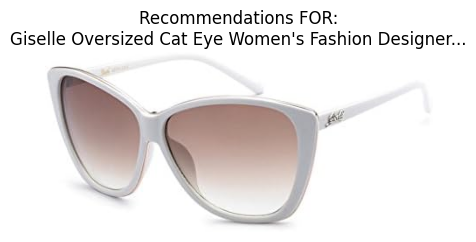


Top 5 Recommendations:


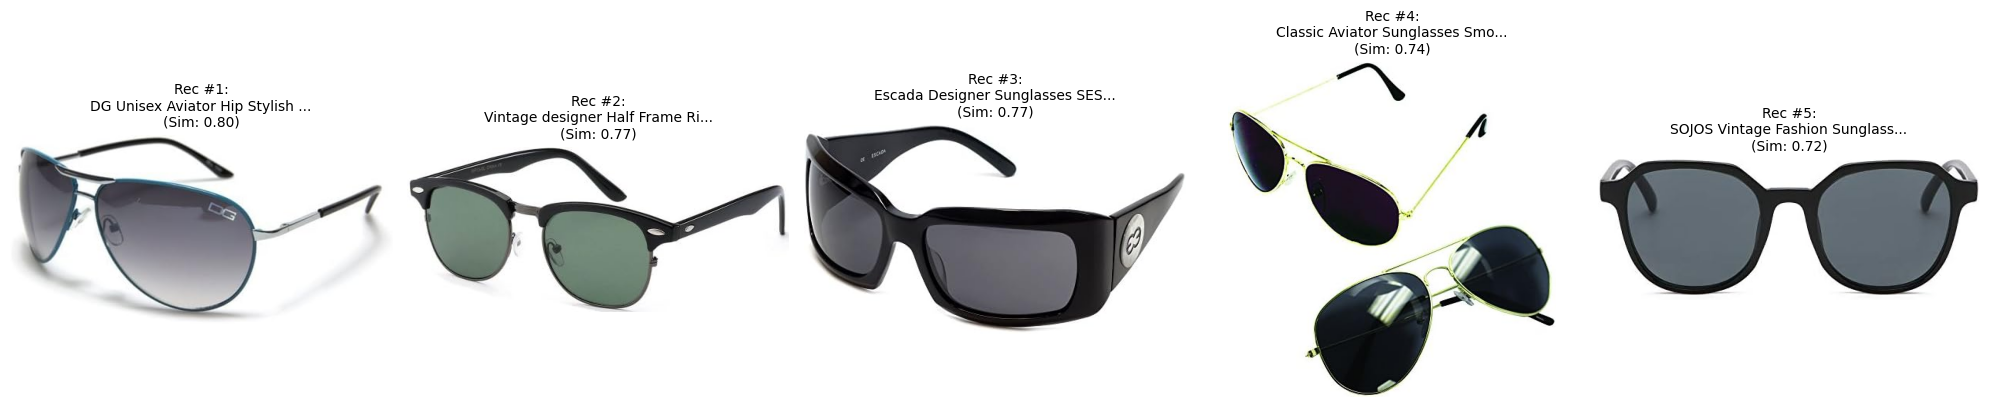

In [21]:

import pandas as pd
import os
import requests
from PIL import Image
from io import BytesIO
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.neighbors import NearestNeighbors
from huggingface_hub import hf_hub_download
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib


print("setting up configuration...")
DATA_SUBSET_SIZE = 1000
IMAGE_DIR = "product_images_image_only" # Use a separate directory
os.makedirs(IMAGE_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"   - using device: {DEVICE}")

print("\n downloading and loading metadata...")
hf_path_meta = hf_hub_download(
    repo_id="glavvrach79/my-recsys-data",
    repo_type="dataset",
    filename="meta_Amazon_Fashion.jsonl",
    subfolder="data"
)

# read the data and filter for items that have images
meta_df = pd.read_json(hf_path_meta, lines=True)
meta_df['image_url'] = meta_df['images'].apply(lambda x: x[0]['large'] if x and isinstance(x, list) and x[0].get('large') else None)
meta_df_with_images = meta_df.dropna(subset=['image_url']).head(DATA_SUBSET_SIZE)
print(f"loaded metadata for {len(meta_df_with_images)} items with images.")

print("\ndownloading product images (this may take a while)...")
image_paths = {}
for index, row in tqdm(meta_df_with_images.iterrows(), total=len(meta_df_with_images), desc="downloading images"):
    item_id = row['parent_asin']
    url = row['image_url']
    image_path = os.path.join(IMAGE_DIR, f"{item_id}.jpg")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(image_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        image_paths[item_id] = image_path
    except Exception as e:
        image_paths[item_id] = None
print("✅ image download complete.")

print("\nextracting features from images using a pre-trained model...")
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.to(DEVICE)
feature_extractor.eval()
preprocess = weights.transforms()

image_embeddings = {}
for item_id, path in tqdm(image_paths.items(), desc="extracting features"):
    if path and os.path.exists(path):
        try:
            img = Image.open(path).convert("RGB")
            img_t = preprocess(img)
            batch_t = torch.unsqueeze(img_t, 0).to(DEVICE)
            with torch.no_grad():
                features = feature_extractor(batch_t)
            image_embeddings[item_id] = features.squeeze().cpu().numpy()
        except Exception as e:
            pass
print("feature extraction complete.")

print("\nbuilding k-nn model on image embeddings...")
item_ids = list(image_embeddings.keys())
embedding_matrix = np.array(list(image_embeddings.values()))
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine') # 5 neighbors + the item itself
nn_model.fit(embedding_matrix)
print("k-nn model built successfully.")

print("\ngenerating sample recommendations...")
random_item_id = np.random.choice(item_ids)
random_item_title = meta_df_with_images[meta_df_with_images['parent_asin'] == random_item_id]['title'].iloc[0]
query_embedding = image_embeddings[random_item_id].reshape(1, -1)
distances, indices = nn_model.kneighbors(query_embedding)

# display the query item first
print(f"\n visually similar recommendations for: '{random_item_title}'")
print("-" * 50)
query_img_path = image_paths.get(random_item_id)
if query_img_path and os.path.exists(query_img_path):
    plt.figure(figsize=(5, 5))
    plt.imshow(Image.open(query_img_path))
    plt.title(f"Recommendations FOR:\n{random_item_title[:50]}...", fontsize=12)
    plt.axis('off')
    plt.show()

# then, display the recommended items in a grid
print("\nTop 5 Recommendations:")
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(1, len(indices[0])):
    ax = axes[i-1]
    neighbor_index = indices[0][i]
    neighbor_id = item_ids[neighbor_index]
    neighbor_title = meta_df_with_images[meta_df_with_images['parent_asin'] == neighbor_id]['title'].iloc[0]
    distance = distances[0][i]
    
    img_path = image_paths.get(neighbor_id)
    if img_path and os.path.exists(img_path):
        ax.imshow(Image.open(img_path))
        ax.set_title(f"Rec #{i}:\n{neighbor_title[:30]}...\n(Sim: {1 - distance:.2f})", fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()


For our sample recommendation, we randomly chose `Giselle Oversized Cat Eye Women's Fashion Designer Sunglasses` as our product. As we can see from the image, they are indeed oversized cat eye sunglasses. All our recommendations offer stylish sunglasses, that are not exactly the same as a oversized cat eye, but are equally stylish that a user might want additionally. These are products Amazon could offer on the home page of the user right after rating `Giselle Oversized Cat Eye Women's Fashion Designer Sunglasses`.

### Hybrid Recommender - Image + Text Embeddings

To further improve our image based recommender, we create a hybrid of our `BERT` and `ResNet` recommenders so we can include both text and images. To do this, we use our saved image embeddings and text embeddings, `item_embeddings_weighted.parquet`. Similar to our other hybrid score, we normalize both embeddings, and this time add a weight 0.50 to both to weigh them equally as important. We then create a combined hybrid embedding using these updated vectors.

Just like our other content based recommenders, we create a KNN model which finds the top 5 most similar products for each product using the cosine similarity of the hybrid embeddings matrix.



setting up configuration...
   - using device: cpu
   - artifacts will be saved to: hybrid_artifacts

loading pre-computed data from local artifacts...
data loaded successfully from cache.

creating hybrid text and image embeddings...
found 1000 items with both image and text embeddings.


creating hybrid vectors: 100%|██████████| 1000/1000 [00:01<00:00, 619.92it/s]


hybrid embeddings created.

building k-nn model on hybrid embeddings...
k-nn model built and saved successfully.

generating a sample recommendation...

 hybrid recommendations for: 'Women's UPF 50+ Sun Protection Hoodie Jackets, Long Sleeves Hiking Outdoor Performance UV Shirts with Pockets'
--------------------------------------------------


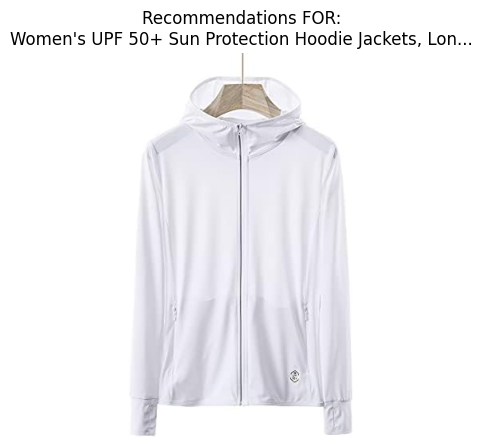


Top 5 Recommendations (Text + Image):


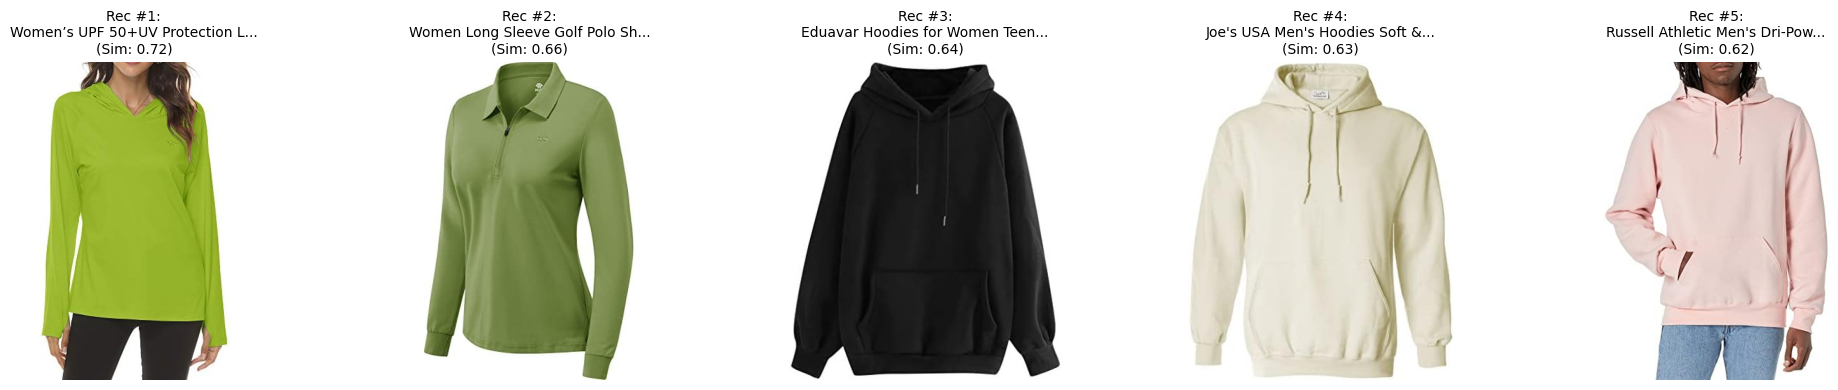

In [22]:
import pandas as pd
import os
import requests
from PIL import Image
from io import BytesIO
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from huggingface_hub import hf_hub_download
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import math

print("setting up configuration...")
DATA_SUBSET_SIZE = 1000
IMAGE_DIR = "product_images"
os.makedirs(IMAGE_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ARTIFACTS_DIR = "hybrid_artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
print(f"   - using device: {DEVICE}")
print(f"   - artifacts will be saved to: {ARTIFACTS_DIR}")

# define paths for saved artifacts
subset_path = os.path.join(ARTIFACTS_DIR, "data_subset.parquet")
image_paths_path = os.path.join(ARTIFACTS_DIR, "image_paths.joblib")
image_embeddings_path = os.path.join(ARTIFACTS_DIR, "image_embeddings.joblib")

if os.path.exists(subset_path) and os.path.exists(image_paths_path) and os.path.exists(image_embeddings_path):
    print("\nloading pre-computed data from local artifacts...")
    data_subset = pd.read_parquet(subset_path)
    image_paths = joblib.load(image_paths_path)
    image_embeddings = joblib.load(image_embeddings_path)
    print("data loaded successfully from cache.")
else:
    print("\n downloading and loading metadata for the first time...")
    hf_path_meta = hf_hub_download(
        repo_id="glavvrach79/my-recsys-data",
        repo_type="dataset",
        filename="meta_Amazon_Fashion.jsonl",
        subfolder="data"
    )
    meta_df = pd.read_json(hf_path_meta, lines=True)
    meta_df['image_url'] = meta_df['images'].apply(lambda x: x[0]['large'] if x and isinstance(x, list) and x[0].get('large') else None)
    
    hf_path_text_emb = hf_hub_download(
        repo_id="glavvrach79/my-recsys-data",
        repo_type="dataset",
        subfolder="output/embeddings",
        filename="item_embeddings_weighted.parquet"
    )
    text_emb_df = pd.read_parquet(hf_path_text_emb)
    
    merged_df = text_emb_df.merge(meta_df[['parent_asin', 'title', 'image_url', 'main_category']], left_on='item_id', right_on='parent_asin')
    data_subset = merged_df.dropna(subset=['image_url']).head(DATA_SUBSET_SIZE)
    data_subset.to_parquet(subset_path)
    print(f"loaded data for {len(data_subset)} items and saved subset to cache.")

    print("\ndownloading product images...")
    image_paths = {}
    for index, row in tqdm(data_subset.iterrows(), total=len(data_subset), desc="downloading images"):
        item_id = row['item_id']
        url = row['image_url']
        image_path = os.path.join(IMAGE_DIR, f"{item_id}.jpg")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(image_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            image_paths[item_id] = image_path
        except Exception as e:
            image_paths[item_id] = None
    joblib.dump(image_paths, image_paths_path)
    print("image download complete and paths saved.")

    print("\nextracting features from images using a pre-trained model...")
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    feature_extractor.to(DEVICE)
    feature_extractor.eval()
    preprocess = weights.transforms()

    image_embeddings = {}
    for item_id, path in tqdm(image_paths.items(), desc="extracting features"):
        if path and os.path.exists(path):
            try:
                img = Image.open(path).convert("RGB")
                img_t = preprocess(img)
                batch_t = torch.unsqueeze(img_t, 0).to(DEVICE)
                with torch.no_grad():
                    features = feature_extractor(batch_t)
                image_embeddings[item_id] = features.squeeze().cpu().numpy()
            except Exception as e:
                pass
    joblib.dump(image_embeddings, image_embeddings_path)
    print("feature extraction complete and embeddings saved.")

print("\ncreating hybrid text and image embeddings...")
hybrid_embeddings = {}
text_weight = 0.5
image_weight = 1 - text_weight

text_emb_df = pd.read_parquet(hf_hub_download(
    repo_id="glavvrach79/my-recsys-data",
    repo_type="dataset",
    subfolder="output/embeddings",
    filename="item_embeddings_weighted.parquet"
))

items_with_both = set(image_embeddings.keys()).intersection(set(text_emb_df['item_id']))
print(f"found {len(items_with_both)} items with both image and text embeddings.")

for item_id in tqdm(items_with_both, desc="creating hybrid vectors"):
    image_vec = image_embeddings[item_id]
    text_vec_row = text_emb_df[text_emb_df['item_id'] == item_id]
    if not text_vec_row.empty:
        text_vec = text_vec_row.filter(regex='^emb_').values[0]
        norm_text_vec = normalize(text_vec.reshape(1, -1)).flatten()
        norm_image_vec = normalize(image_vec.reshape(1, -1)).flatten()
        hybrid_vec = np.concatenate([text_weight * norm_text_vec, image_weight * norm_image_vec])
        hybrid_embeddings[item_id] = hybrid_vec
print("hybrid embeddings created.")

print("\nbuilding k-nn model on hybrid embeddings...")
item_ids = list(hybrid_embeddings.keys())
embedding_matrix = np.array(list(hybrid_embeddings.values()))
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_model.fit(embedding_matrix)
# save the model and the item ids for the metrics script
joblib.dump(nn_model, os.path.join(ARTIFACTS_DIR, "content_knn_model.joblib"))
joblib.dump(item_ids, os.path.join(ARTIFACTS_DIR, "content_item_ids.joblib"))
print("k-nn model built and saved successfully.")

print("\ngenerating a sample recommendation...")
random_item_id = np.random.choice(item_ids)
random_item_title = data_subset[data_subset['parent_asin'] == random_item_id]['title'].iloc[0]
query_embedding = hybrid_embeddings[random_item_id].reshape(1, -1)
distances, indices = nn_model.kneighbors(query_embedding)

print(f"\n hybrid recommendations for: '{random_item_title}'")
print("-" * 50)
query_img_path = image_paths.get(random_item_id)
if query_img_path and os.path.exists(query_img_path):
    plt.figure(figsize=(5, 5))
    plt.imshow(Image.open(query_img_path))
    plt.title(f"Recommendations FOR:\n{random_item_title[:50]}...", fontsize=12)
    plt.axis('off')
    plt.show()

print("\nTop 5 Recommendations (Text + Image):")
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(1, len(indices[0])):
    ax = axes[i-1]
    neighbor_index = indices[0][i]
    neighbor_id = item_ids[neighbor_index]
    neighbor_title = data_subset[data_subset['parent_asin'] == neighbor_id]['title'].iloc[0]
    distance = distances[0][i]
    
    img_path = image_paths.get(neighbor_id)
    if img_path and os.path.exists(img_path):
        ax.imshow(Image.open(img_path))
        ax.set_title(f"Rec #{i}:\n{neighbor_title[:30]}...\n(Sim: {1 - distance:.2f})", fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()


For our sample recommendations, we take a look at `Women's UPF 50+ Sun Protection Hoodie Jackets, Long Sleeves Hiking Outdoor Performance UV Shirts with Pockets`. The top recommended item looks very similar to our original jacket as it also has UPF 50+ Protection. We can also see there is diverse set of recommendations here. They don't all look exactly the same, but they are all most definitely similar in that they are all athletic/outdoor jackets.

### Evaluation Metrics

It is not enough to rely solely on RMSE to evaluate our model. We are making recommendations for humans, so as data scientists we must make sure our models produce fair, diverse results for customer satisfaction. We do not want a model that produces the same few overfitted items, reinforces human bias, never predicts new items or never surprises a user. To address these potential issues, we will use the below metrics for model evaluation:

* Diversity: The extent to which recommended items differ from each other
* Serendipity: The ability to recommend unexpected yet relevant items that pleasantly
surprise the user
* Novelty: The degree to which recommended items are new or unknown to the user

Here we will take a look at our evaluation metrics for our new image and text analysis recommender.

In [23]:
import pandas as pd
import os
import numpy as np
import joblib
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import math

print("setting up configuration for evaluation")
ARTIFACTS_DIR = "hybrid_artifacts"
EVAL_SAMPLE_SIZE = 100
K = 5

print("\nloading artifacts for evaluation...")
try:
    data_subset = pd.read_parquet(os.path.join(ARTIFACTS_DIR, "data_subset.parquet"))
    hybrid_embeddings = joblib.load(os.path.join(ARTIFACTS_DIR, "hybrid_embeddings.joblib"))
    item_ids = joblib.load(os.path.join(ARTIFACTS_DIR, "content_item_ids.joblib"))
    nn_model = joblib.load(os.path.join(ARTIFACTS_DIR, "content_knn_model.joblib"))
    print("artifacts loaded successfully.")
except FileNotFoundError:
    print("error: artifacts not found. please run the main recommender script first.")

if 'data_subset' in locals(): # Check if data loaded successfully
    print(f"\ncalculating evaluation metrics over a sample of {EVAL_SAMPLE_SIZE} items...")
    diversity_scores = []
    precision_scores = []
    novelty_scores = []
    serendipity_scores = []

    # create lookups for item categories and popularity
    item_to_category = data_subset.set_index('item_id')['main_category'].to_dict()
    item_popularity = data_subset['item_id'].value_counts(normalize=True).to_dict()
    novelty_threshold = data_subset['item_id'].value_counts(normalize=True).quantile(0.5)

    eval_item_ids = np.random.choice(item_ids, size=min(EVAL_SAMPLE_SIZE, len(item_ids)), replace=False)

    for item_id in tqdm(eval_item_ids, desc="calculating metrics"):
        query_embedding = hybrid_embeddings.get(item_id)
        if query_embedding is None:
            continue
            
        distances, indices = nn_model.kneighbors(query_embedding.reshape(1, -1))
        rec_ids = [item_ids[i] for i in indices[0][1:]]
        
        # Calculate Diversity
        rec_vectors = [hybrid_embeddings[rec_id] for rec_id in rec_ids if rec_id in hybrid_embeddings]
        if len(rec_vectors) > 1:
            sim_matrix = cosine_similarity(rec_vectors)
            upper_triangle_indices = np.triu_indices(len(rec_vectors), k=1)
            diversity = 1 - np.mean(sim_matrix[upper_triangle_indices])
            diversity_scores.append(diversity)

        # Calculate Novelty, Precision, and Serendipity
        query_category = item_to_category.get(item_id)
        if query_category:
            correct_predictions = 0
            serendipitous_recs = 0
            
            for rec_id in rec_ids:
                pop = item_popularity.get(rec_id, 1.0)
                novelty_scores.append(-math.log2(pop))
                
                is_relevant = item_to_category.get(rec_id) == query_category
                if is_relevant:
                    correct_predictions += 1
                
                is_novel = pop < novelty_threshold
                if is_relevant and is_novel:
                    serendipitous_recs += 1

            precision = correct_predictions / K
            precision_scores.append(precision)
            
            serendipity = serendipitous_recs / K
            serendipity_scores.append(serendipity)

    # calculate and print the final average scores
    mean_diversity = np.mean(diversity_scores) if diversity_scores else 0
    mean_precision = np.mean(precision_scores) if precision_scores else 0
    mean_novelty = np.mean(novelty_scores) if novelty_scores else 0
    mean_serendipity = np.mean(serendipity_scores) if serendipity_scores else 0

    print("\n--- Evaluation Metrics ---")
    print(f"Mean Intra-List Diversity: {mean_diversity:.4f} (scale 0-1, higher is better)")
    print(f"Mean Category Precision@{K}: {mean_precision:.2%} (percent of recs in the same category)")
    print(f"Mean Novelty:              {mean_novelty:.4f} (higher is better, based on information theory)")
    print(f"Mean Serendipity@{K}:        {mean_serendipity:.2%} (percent of recs that are novel and relevant)")


setting up configuration for evaluation

loading artifacts for evaluation...
artifacts loaded successfully.

calculating evaluation metrics over a sample of 100 items...


calculating metrics: 100%|██████████| 100/100 [00:01<00:00, 58.10it/s]


--- Evaluation Metrics ---
Mean Intra-List Diversity: 0.4629 (scale 0-1, higher is better)
Mean Category Precision@5: 100.00% (percent of recs in the same category)
Mean Novelty:              9.9658 (higher is better, based on information theory)
Mean Serendipity@5:        0.00% (percent of recs that are novel and relevant)


In [24]:
# imports
import pandas as pd
import os
import numpy as np
import joblib
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import math
from huggingface_hub import hf_hub_download

print("setting up configuration for evaluation...")
ARTIFACTS_DIR = "hybrid_artifacts"
EVAL_SAMPLE_SIZE = 100
K = 5

print("\nloading artifacts for evaluation...")
try:
    data_subset = pd.read_parquet(os.path.join(ARTIFACTS_DIR, "data_subset.parquet"))
    # load both image and text embeddings
    image_embeddings = joblib.load(os.path.join(ARTIFACTS_DIR, "image_embeddings.joblib"))
    text_emb_df = pd.read_parquet(hf_hub_download(
        repo_id="glavvrach79/my-recsys-data",
        repo_type="dataset",
        subfolder="output/embeddings",
        filename="item_embeddings_weighted.parquet"
    ))
    
    # load the correctly named artifact files
    item_ids_from_knn = joblib.load(os.path.join(ARTIFACTS_DIR, "content_item_ids.joblib"))
    nn_model = joblib.load(os.path.join(ARTIFACTS_DIR, "content_knn_model.joblib"))
    print("artifacts loaded successfully.")
except FileNotFoundError:
    print("error: artifacts not found. please run the main recommender script first.")
    exit()

print("\nrecreating hybrid embeddings to match the k-NN model...")
hybrid_embeddings = {}
text_weight = 0.5
image_weight = 1 - text_weight

items_with_both = set(image_embeddings.keys()).intersection(set(text_emb_df['item_id']))

for item_id in tqdm(items_with_both, desc="recreating hybrid vectors"):
    image_vec = image_embeddings.get(item_id)
    text_vec_row = text_emb_df[text_emb_df['item_id'] == item_id]
    
    if image_vec is not None and not text_vec_row.empty:
        text_vec = text_vec_row.filter(regex='^emb_').values[0]
        norm_text_vec = normalize(text_vec.reshape(1, -1)).flatten()
        norm_image_vec = normalize(image_vec.reshape(1, -1)).flatten()
        hybrid_vec = np.concatenate([text_weight * norm_text_vec, image_weight * norm_image_vec])
        hybrid_embeddings[item_id] = hybrid_vec
print(" hybrid embeddings recreated successfully.")


print(f"\ncalculating evaluation metrics over a sample of {EVAL_SAMPLE_SIZE} items...")
diversity_scores = []
precision_scores = []
novelty_scores = []
serendipity_scores = []

# create lookups for item categories and popularity
item_to_category = data_subset.set_index('item_id')['main_category'].to_dict()
item_popularity = data_subset['item_id'].value_counts(normalize=True).to_dict()
novelty_threshold = data_subset['item_id'].value_counts(normalize=True).quantile(0.5)

eval_item_ids = np.random.choice(item_ids_from_knn, size=min(EVAL_SAMPLE_SIZE, len(item_ids_from_knn)), replace=False)

for item_id in tqdm(eval_item_ids, desc="calculating metrics"):
    # get recommendations for the item
    query_embedding = hybrid_embeddings.get(item_id)
    if query_embedding is None:
        continue # skip if the item doesn't have a hybrid embedding
        
    distances, indices = nn_model.kneighbors(query_embedding.reshape(1, -1))
    rec_ids = [item_ids_from_knn[i] for i in indices[0][1:]] # exclude the item itself
    
    # diversity
    rec_vectors = [hybrid_embeddings[rec_id] for rec_id in rec_ids if rec_id in hybrid_embeddings]
    if len(rec_vectors) > 1:
        sim_matrix = cosine_similarity(rec_vectors)
        upper_triangle_indices = np.triu_indices(len(rec_vectors), k=1)
        diversity = 1 - np.mean(sim_matrix[upper_triangle_indices])
        diversity_scores.append(diversity)

    #novelty, precision, and serendipity
    query_category = item_to_category.get(item_id)
    if query_category:
        correct_predictions = 0
        serendipitous_recs = 0
        
        for rec_id in rec_ids:
            # novelty calculation
            pop = item_popularity.get(rec_id, 1.0)
            novelty_scores.append(-math.log2(pop))
            
            # precision calculation
            is_relevant = item_to_category.get(rec_id) == query_category
            if is_relevant:
                correct_predictions += 1
            
            # serendipity calculation
            is_novel = pop < novelty_threshold
            if is_relevant and is_novel:
                serendipitous_recs += 1

        precision = correct_predictions / K
        precision_scores.append(precision)
        
        serendipity = serendipitous_recs / K
        serendipity_scores.append(serendipity)

# calculate and print the final average scores
mean_diversity = np.mean(diversity_scores) if diversity_scores else 0
mean_precision = np.mean(precision_scores) if precision_scores else 0
mean_novelty = np.mean(novelty_scores) if novelty_scores else 0
mean_serendipity = np.mean(serendipity_scores) if serendipity_scores else 0

print("\n--- Evaluation Metrics ---")
print(f"Mean Intra-List Diversity: {mean_diversity:.4f} (scale 0-1, higher is better)")
print(f"Mean Category Precision@{K}: {mean_precision:.2%} (percent of recs in the same category)")
print(f"Mean Novelty:              {mean_novelty:.4f} (higher is better, based on information theory)")
print(f"Mean Serendipity@{K}:        {mean_serendipity:.2%} (percent of recs that are novel and relevant)")


setting up configuration for evaluation...

loading artifacts for evaluation...
artifacts loaded successfully.

recreating hybrid embeddings to match the k-NN model...


recreating hybrid vectors: 100%|██████████| 1000/1000 [00:01<00:00, 637.91it/s]


 hybrid embeddings recreated successfully.

calculating evaluation metrics over a sample of 100 items...


calculating metrics: 100%|██████████| 100/100 [00:01<00:00, 52.94it/s]


--- Evaluation Metrics ---
Mean Intra-List Diversity: 0.4752 (scale 0-1, higher is better)
Mean Category Precision@5: 100.00% (percent of recs in the same category)
Mean Novelty:              9.9658 (higher is better, based on information theory)
Mean Serendipity@5:        0.00% (percent of recs that are novel and relevant)


For image and text analysis recommender, we have a diversity score 0f 0.4752, Category Precision of 100%, novelty score of 9.9658, and serendipity of 0%. This means that all of our items were in the same category and included a mix of diverse and similar items. Serendipity could be improved with a value of 0%, meaning that the recommendations are new to the user.

Some steps we can do to improve these scores include MMR (Maximal Marginal Relevance) which is a re-ranking algorithm used to make recommendation lists both relevant and diverse. Another method is popularity penalization function which prevents favoring popular items (popularity bias). It directly controls the trade-off between the model's original "relevance" prediction and the goal of increasing recommendation "novelty".

In [ ]:

import pandas as pd
import os
import numpy as np
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql.functions import col, explode, collect_list, lit, udf
from pyspark.sql.types import FloatType
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import joblib


print("setting up configuration for evaluation...")
ARTIFACTS_DIR = "recommender_artifacts"
K = 10  # the "k" for our @k metrics
spark = None # initialize for the finally block

try:
    print("\nloading pre-computed artifacts for evaluation...")
    # start a spark session to load the data
    spark = SparkSession.builder.appName("Evaluation").getOrCreate()

    # load the trained ALS model
    als_model_path = os.path.join(ARTIFACTS_DIR, "als_model")
    if not os.path.exists(als_model_path):
        raise FileNotFoundError("ALS model not found. Please run the main training pipeline first.")
    als_model = ALSModel.load(als_model_path)

    # load the full user history, which contains our ground truth data
    full_history_path = os.path.join(ARTIFACTS_DIR, "full_user_history.parquet")
    if not os.path.exists(full_history_path):
        raise FileNotFoundError("User history not found. Please run the main training pipeline first.")
    full_history = spark.read.parquet(full_history_path)

    # load the hybrid embeddings to calculate diversity
    hybrid_item_ids = joblib.load(os.path.join(ARTIFACTS_DIR, "hybrid_item_ids.joblib"))
    nn_model = joblib.load(os.path.join(ARTIFACTS_DIR, "hybrid_knn_model.joblib"))
    hybrid_embeddings = {pid: vec for pid, vec in zip(hybrid_item_ids, nn_model._fit_X)}

    print("artifacts loaded successfully.")


    print("\npreparing data for metrics calculation...")

    # let's define a "liked" item as one the user rated 4 or 5 stars
    relevant_items_df = full_history.filter(col("rating") >= 4.0)

    # create a dataframe where each row is a user and a list of all items they liked
    ground_truth_df = relevant_items_df.groupBy("userIntId").agg(
        collect_list("productIntId").alias("relevant_items")
    )

    # generate top K recommendations for all users in our ground truth set
    users_to_evaluate = ground_truth_df.select("userIntId").withColumnRenamed("userIntId", "user")
    all_recommendations = als_model.recommendForUserSubset(users_to_evaluate, K)

    # join recommendations with ground truth
    recs_and_truth = all_recommendations.join(
        ground_truth_df,
        all_recommendations.user == ground_truth_df.userIntId
    ).select(
        "user",
        col("recommendations.item").alias("recommended_items"),
        "relevant_items"
    )
    recs_and_truth.cache() # cache this for performance
    print("data prepared.")

    # --- 3. CALCULATE RANKING METRICS ---
    print("\ncalculating ranking metrics...")

    # define UDFs to calculate precision and recall for a single user
    def precision_at_k(recs, truth, k):
        recs_set = set(recs[:k])
        truth_set = set(truth)
        intersection_size = len(recs_set.intersection(truth_set))
        return intersection_size / k if k > 0 else 0.0

    def recall_at_k(recs, truth, k):
        recs_set = set(recs[:k])
        truth_set = set(truth)
        intersection_size = len(recs_set.intersection(truth_set))
        return intersection_size / len(truth_set) if len(truth_set) > 0 else 0.0

    precision_udf = udf(lambda recs, truth: precision_at_k(recs, truth, K), FloatType())
    recall_udf = udf(lambda recs, truth: recall_at_k(recs, truth, K), FloatType())

    # calculate precision and recall for all users
    metric_df = recs_and_truth.withColumn("precision", precision_udf(col("recommended_items"), col("relevant_items"))) \
                             .withColumn("recall", recall_udf(col("recommended_items"), col("relevant_items")))

    # calculate the average (mean) of these metrics across all users
    mean_metrics = metric_df.agg(
        col("precision").alias("mean_precision"),
        col("recall").alias("mean_recall")
    ).first()

    print(f"   - Mean Precision@{K}: {mean_metrics['mean_precision']:.4f}")
    print(f"   - Mean Recall@{K}:    {mean_metrics['mean_recall']:.4f}")

    print("\ncalculating beyond-accuracy metrics...")

    # calculate coverage
    all_rec_items = all_recommendations.select(explode("recommendations.item").alias("item")).distinct()
    num_recommended_items = all_rec_items.count()
    total_items = full_history.select("productIntId").distinct().count()
    coverage = num_recommended_items / total_items if total_items > 0 else 0.0
    print(f"   - Catalog Coverage: {coverage:.2%} ({num_recommended_items} out of {total_items} items were recommended)")

    # calculate diversity
    # note: this is computationally intensive and is done on a sample of users
    def intra_list_diversity(recs, embeddings, k):
        rec_asins = [id_to_asin_map.get(item_id) for item_id in recs[:k]]
        rec_vectors = [embeddings.get(asin) for asin in rec_asins if asin in embeddings]

        if len(rec_vectors) < 2:
            return 0.0 # diversity is 0 if there's only one item

        # calculate average cosine distance (1 - similarity)
        distances = []
        for v1, v2 in combinations(rec_vectors, 2):
            sim = cosine_similarity([v1], [v2])[0][0]
            distances.append(1 - sim)

        return np.mean(distances) if distances else 0.0

    # we need a map from productIntId to parent_asin for this
    id_to_asin_map = {row['productIntId']: row['parent_asin'] for row in full_history.select("productIntId", "parent_asin").distinct().collect()}

    # run on a pandas dataframe for easier iteration
    recs_pd = recs_and_truth.limit(100).toPandas() # calculate on a sample of 100 users
    recs_pd['diversity'] = recs_pd.apply(
        lambda row: intra_list_diversity(row['recommended_items'], hybrid_embeddings, K),
        axis=1
    )
    mean_diversity = recs_pd['diversity'].mean()
    print(f"   - Mean Intra-List Diversity: {mean_diversity:.4f} (higher is better, scale is 0-1)")

finally:
    if spark:
        spark.stop()
        print("\nevaluation complete. spark session stopped.")


## Deploying Our App Recommender

We deployed one of image analysis recommenders on HF https://huggingface.co/spaces/glavvrach79/recsys

The steps to use the recommender are:

* Upload an image
* Declare the numer of recommendations
* Hit submit

Our recommender will then display the top K recommended items (with images) along with the item similarity score.

## Conclusion

For this project we looked into many different recommender systems such as:

* Content based model: A model that used BERT which is able to use user reviews to create item embeddings. This recommender found the most similar items using the cosine similarity.
* Collaborative filtering model: A model that used Spark's ALS model to narrow down our ratings matrix using user preferences. This found recommended items by taking the dot product of user and product latent feature vectors.
* Hybrid recommender: This leverages both models by a retrieval and reranking process. This took our ALS recommended items and reranked them based off the similarity score the BERT model calculated.
* Image analysis recommender: This model used the raw images for products to create item embeddings. This recommender also found the most similar items using the cosine similarity. Through this recommender we were able to visually see how recommendations, and how it might look if Amazon recommended these products.
* Image + Text analysis recommender: This model used a hybrid of the image and text embeddings for products. This recommender also found the most similar items using the cosine similarity.

Evaluating a Model:

We also took a look at how to evaluate a model. We can not simply rely on the math of an algorithm to make user predictions. We must remember the target for these recommenders are humans, and it is simply not enough to look at a model's accuracy. We must "surprise" users with new content, include a diverse set of items and at the same time deliver relevant items. Based off the data and the recommender, we must decide on what is the right balance between all of these metrics that will make the user happy. It is also important to not reinforce human bias in recommenders. Society is biased, so recommender systems modeled on user behavior are inherently biased as well.

Deploying a Recommender:

We finally deployed our image analysis based recommender on HF. This has a simple UI where a user can drop an image, our recommender will visually output the recommended items, including the similarity score of each item.

Future Directions:

One thing that could be done to improve our model is to allow user feedback for the recommendations directly. If we were building a recommender for Amazon, we could include a "Show Me Something Different" button. Giving users a button or a slider to control how much exploration they want puts them in the driver's seat. An even better option is using AI-Powered Exploration (The Conversational Approach). This way the user can directly interact with the recommender, and have a conversation with it. The user can explain exactly what he wants, and AI can use the additional info to create more useful and personalized recommendations.

